# Optuna Tuning | RandomForestClassifier
**RandomForestClassifier** hyper-parameter tuning for the [UCI dataset](https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008). The dataset represents ten years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks.

> **[CAUTION]** Do <u>NOT</u> execute "Run All", that will tell Optuna to run hyper-parameter tuning, regardless of whether you have already done it or not. Avoid running the _"Hyper-parameter tuning"_ subsections if you don't have to.

## **0. Initial Setup**
Taking care of package imports, defining work constants, and loading all necessary datasets.

### 0.1 Python imports

In [12]:
# Data Analysis
import numpy as np
import pandas as pd

# Hyperparameter optimization
import optuna

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Visualization configurations
pd.set_option('display.max_columns', 60)
plt.style.use('ggplot')
sns.set_style('white')

In [13]:
from collections import Counter

from imblearn.combine import SMOTETomek
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks

from optuna.storages import JournalStorage
from optuna.storages.journal import JournalFileBackend

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, fbeta_score, make_scorer, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler

### 0.2 Constants

In [14]:
DATA_PATH = '../data/original/'
DATA_PATH_PROCESSED = '../data/processed/'

MODEL_NAME = 'rf' # Modify this to the model you are using

OPTUNA_PATH = '../optuna/'
OPTUNA_DIR = OPTUNA_PATH + MODEL_NAME + '/'

STUDY_NAME = "Diabetes_130-US"
STUDY_PATH_NONE = OPTUNA_DIR + f"optuna_{MODEL_NAME}_none.log"
STUDY_PATH_RUS = OPTUNA_DIR + f"optuna_{MODEL_NAME}_rus.log"
STUDY_PATH_SMOTE = OPTUNA_DIR + f"optuna_{MODEL_NAME}_smote.log"
STUDY_PATH_SMOTE_TOMEK = OPTUNA_DIR + f"optuna_{MODEL_NAME}_smote-tomek.log"

N_TRIALS = 100
RANDOM_STATE = 38

SCORE_NAME = 'F1-Score'
SCORING = make_scorer(fbeta_score, beta=1, average='macro')

### 0.3 Loading datasets

In [15]:
train_set = pd.read_csv(
    DATA_PATH_PROCESSED + 'train.csv',
    na_values='?',
    keep_default_na=False
)

test_set = pd.read_csv(
    DATA_PATH_PROCESSED + 'test.csv',
    na_values='?',
    keep_default_na=False
)

## **1. Feature Scaling**
Applying scaling to numerical features.

In [16]:
target = 'readmitted'

X_train = train_set.drop(target, axis=1)
y_train = train_set[target]

X_test = test_set.drop(target, axis=1)
y_test = test_set[target]

### 1.1 Scaling
Applying scaling to numerical features, while leaving boolean features untouched.

In [17]:
NUMERICAL_COLUMNS = [
    'time_in_hospital', 'age', 'num_lab_procedures',
    'num_diagnoses', 'num_inpatient'
]

In [18]:
scaler = StandardScaler()

X_train[NUMERICAL_COLUMNS] = scaler.fit_transform(X_train[NUMERICAL_COLUMNS])
X_test[NUMERICAL_COLUMNS] = scaler.transform(X_test[NUMERICAL_COLUMNS])

In [19]:
print('Train set:', Counter(y_train))
print('Test set:', Counter(y_test))

Train set: Counter({0: 37607, 1: 4441})
Test set: Counter({0: 16117, 1: 1904})


## **2. Optuna Hyper-parameter Tuning | No under/oversampling**
Hyper-parameter tuning of the model using Optuna, with no undersampling/oversampling.

### 2.1 Objective & study setup
Preparing the objective function with all hyper-parameters, and creating/loading the Optuna study.

In [20]:
def objective(trial: optuna.Trial) -> float:
    # Hyperparameter search space
    params = {
        "n_estimators": 100,
        "max_depth": trial.suggest_int("max_depth", 4, 30, step=2),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 60, step=2)
    }
    
    # Define validation folds
    kf = StratifiedKFold(n_splits=5, shuffle=False)
    model = RandomForestClassifier(**params, random_state=RANDOM_STATE)
    
    # Cross validation
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring=SCORING)

    print("Cross validation scores: {}".format(scores))
    print("Average score: {}".format(scores.mean()))

    return scores.mean()

In [21]:
# Set up study with name and storage
storage = JournalStorage(JournalFileBackend(STUDY_PATH_NONE))

study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(constant_liar=True, seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.INFO)

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2024-12-30 14:06:44,756] A new study created in Journal with name: Diabetes_130-US


### 2.2 Hyper-parameter tuning
**(CAUTION)** <u>Do not run</u>, unless you already need to find the best parameters. If you already have bound the best model configuration, <u>run the section above</u> _(Objective & study setup)_.

In [22]:
study.optimize(
    objective,
    n_trials=N_TRIALS,
    n_jobs=-1 # Use all available cores
)

[I 2024-12-30 14:06:54,156] Trial 0 finished with value: 0.47212353264706886 and parameters: {'max_depth': 8, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.47212353264706886.


Cross validation scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average score: 0.47212353264706886
Cross validation scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average score: 0.47212353264706886


[I 2024-12-30 14:06:54,355] Trial 3 finished with value: 0.47212353264706886 and parameters: {'max_depth': 8, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.47212353264706886.
[I 2024-12-30 14:06:54,956] Trial 7 finished with value: 0.47212353264706886 and parameters: {'max_depth': 10, 'min_samples_leaf': 26}. Best is trial 0 with value: 0.47212353264706886.
[I 2024-12-30 14:06:55,138] Trial 8 finished with value: 0.47212353264706886 and parameters: {'max_depth': 12, 'min_samples_leaf': 56}. Best is trial 0 with value: 0.47212353264706886.


Cross validation scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average score: 0.47212353264706886
Cross validation scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average score: 0.47212353264706886


[I 2024-12-30 14:06:55,363] Trial 1 finished with value: 0.47212353264706886 and parameters: {'max_depth': 24, 'min_samples_leaf': 56}. Best is trial 0 with value: 0.47212353264706886.


Cross validation scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average score: 0.47212353264706886


[I 2024-12-30 14:06:56,027] Trial 6 finished with value: 0.47212353264706886 and parameters: {'max_depth': 26, 'min_samples_leaf': 34}. Best is trial 0 with value: 0.47212353264706886.


Cross validation scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average score: 0.47212353264706886


[I 2024-12-30 14:06:56,594] Trial 11 finished with value: 0.47212353264706886 and parameters: {'max_depth': 30, 'min_samples_leaf': 24}. Best is trial 0 with value: 0.47212353264706886.
[I 2024-12-30 14:06:56,652] Trial 4 finished with value: 0.47212353264706886 and parameters: {'max_depth': 24, 'min_samples_leaf': 22}. Best is trial 0 with value: 0.47212353264706886.


Cross validation scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average score: 0.47212353264706886
Cross validation scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average score: 0.47212353264706886


[I 2024-12-30 14:06:57,260] Trial 5 finished with value: 0.47212353264706886 and parameters: {'max_depth': 24, 'min_samples_leaf': 16}. Best is trial 0 with value: 0.47212353264706886.


Cross validation scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average score: 0.47212353264706886


[I 2024-12-30 14:06:57,648] Trial 10 finished with value: 0.4728022174712427 and parameters: {'max_depth': 14, 'min_samples_leaf': 4}. Best is trial 10 with value: 0.4728022174712427.


Cross validation scores: [0.47328605 0.47213156 0.47318285 0.47328256 0.47212806]
Average score: 0.4728022174712427


[I 2024-12-30 14:06:58,003] Trial 2 finished with value: 0.47212353264706886 and parameters: {'max_depth': 30, 'min_samples_leaf': 8}. Best is trial 10 with value: 0.4728022174712427.


Cross validation scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average score: 0.47212353264706886


[I 2024-12-30 14:06:58,449] Trial 9 finished with value: 0.47235443173114716 and parameters: {'max_depth': 26, 'min_samples_leaf': 6}. Best is trial 10 with value: 0.4728022174712427.


Cross validation scores: [0.47328605 0.47213156 0.47209842 0.47212806 0.47212806]
Average score: 0.47235443173114716


[I 2024-12-30 14:07:03,301] Trial 15 finished with value: 0.47212353264706886 and parameters: {'max_depth': 6, 'min_samples_leaf': 20}. Best is trial 10 with value: 0.4728022174712427.


Cross validation scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average score: 0.47212353264706886


[I 2024-12-30 14:07:04,670] Trial 12 finished with value: 0.47212353264706886 and parameters: {'max_depth': 14, 'min_samples_leaf': 54}. Best is trial 10 with value: 0.4728022174712427.


Cross validation scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average score: 0.47212353264706886


[I 2024-12-30 14:07:04,990] Trial 22 finished with value: 0.47212353264706886 and parameters: {'max_depth': 4, 'min_samples_leaf': 12}. Best is trial 10 with value: 0.4728022174712427.
[I 2024-12-30 14:07:05,182] Trial 17 finished with value: 0.47212353264706886 and parameters: {'max_depth': 8, 'min_samples_leaf': 30}. Best is trial 10 with value: 0.4728022174712427.


Cross validation scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average score: 0.47212353264706886
Cross validation scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average score: 0.47212353264706886


[I 2024-12-30 14:07:06,502] Trial 14 finished with value: 0.47212353264706886 and parameters: {'max_depth': 26, 'min_samples_leaf': 28}. Best is trial 10 with value: 0.4728022174712427.


Cross validation scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average score: 0.47212353264706886


[I 2024-12-30 14:07:07,289] Trial 18 finished with value: 0.47212353264706886 and parameters: {'max_depth': 22, 'min_samples_leaf': 54}. Best is trial 10 with value: 0.4728022174712427.


Cross validation scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average score: 0.47212353264706886


[I 2024-12-30 14:07:07,655] Trial 19 finished with value: 0.47212353264706886 and parameters: {'max_depth': 20, 'min_samples_leaf': 44}. Best is trial 10 with value: 0.4728022174712427.


Cross validation scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average score: 0.47212353264706886


[I 2024-12-30 14:07:08,138] Trial 16 finished with value: 0.47212353264706886 and parameters: {'max_depth': 26, 'min_samples_leaf': 12}. Best is trial 10 with value: 0.4728022174712427.


Cross validation scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average score: 0.47212353264706886


[I 2024-12-30 14:07:08,501] Trial 20 finished with value: 0.47212353264706886 and parameters: {'max_depth': 14, 'min_samples_leaf': 34}. Best is trial 10 with value: 0.4728022174712427.
[I 2024-12-30 14:07:08,542] Trial 21 finished with value: 0.47212353264706886 and parameters: {'max_depth': 18, 'min_samples_leaf': 46}. Best is trial 10 with value: 0.4728022174712427.
[I 2024-12-30 14:07:08,587] Trial 13 finished with value: 0.47258533151549786 and parameters: {'max_depth': 24, 'min_samples_leaf': 4}. Best is trial 10 with value: 0.4728022174712427.


Cross validation scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average score: 0.47212353264706886
Cross validation scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average score: 0.47212353264706886
Cross validation scores: [0.47328605 0.47213156 0.47209842 0.47328256 0.47212806]
Average score: 0.47258533151549786


[I 2024-12-30 14:07:10,835] Trial 23 finished with value: 0.47212353264706886 and parameters: {'max_depth': 16, 'min_samples_leaf': 12}. Best is trial 10 with value: 0.4728022174712427.


Cross validation scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average score: 0.47212353264706886


[I 2024-12-30 14:07:14,911] Trial 32 finished with value: 0.47212353264706886 and parameters: {'max_depth': 4, 'min_samples_leaf': 8}. Best is trial 10 with value: 0.4728022174712427.


Cross validation scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average score: 0.47212353264706886


[I 2024-12-30 14:07:15,317] Trial 24 finished with value: 0.47212353264706886 and parameters: {'max_depth': 18, 'min_samples_leaf': 16}. Best is trial 10 with value: 0.4728022174712427.


Cross validation scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average score: 0.47212353264706886


[I 2024-12-30 14:07:15,606] Trial 26 finished with value: 0.47212353264706886 and parameters: {'max_depth': 14, 'min_samples_leaf': 40}. Best is trial 10 with value: 0.4728022174712427.


Cross validation scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average score: 0.47212353264706886


[I 2024-12-30 14:07:17,041] Trial 27 finished with value: 0.47212353264706886 and parameters: {'max_depth': 28, 'min_samples_leaf': 18}. Best is trial 10 with value: 0.4728022174712427.


Cross validation scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average score: 0.47212353264706886


[I 2024-12-30 14:07:17,344] Trial 29 finished with value: 0.47212353264706886 and parameters: {'max_depth': 10, 'min_samples_leaf': 8}. Best is trial 10 with value: 0.4728022174712427.


Cross validation scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average score: 0.47212353264706886


[I 2024-12-30 14:07:18,512] Trial 33 finished with value: 0.4723478046652483 and parameters: {'max_depth': 10, 'min_samples_leaf': 2}. Best is trial 10 with value: 0.4728022174712427.


Cross validation scores: [0.47213156 0.47213156 0.47206529 0.47328256 0.47212806]
Average score: 0.4723478046652483


[I 2024-12-30 14:07:19,323] Trial 25 finished with value: 0.4732872294982357 and parameters: {'max_depth': 20, 'min_samples_leaf': 2}. Best is trial 25 with value: 0.4732872294982357.


Cross validation scores: [0.47290759 0.47304523 0.47301083 0.47314494 0.47432755]
Average score: 0.4732872294982357


[I 2024-12-30 14:07:19,579] Trial 28 finished with value: 0.47235443243141956 and parameters: {'max_depth': 20, 'min_samples_leaf': 6}. Best is trial 25 with value: 0.4732872294982357.
[I 2024-12-30 14:07:19,774] Trial 30 finished with value: 0.47212353264706886 and parameters: {'max_depth': 16, 'min_samples_leaf': 10}. Best is trial 25 with value: 0.4732872294982357.


Cross validation scores: [0.47213156 0.47213156 0.47209842 0.47328256 0.47212806]
Average score: 0.47235443243141956
Cross validation scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average score: 0.47212353264706886


[I 2024-12-30 14:07:20,061] Trial 31 finished with value: 0.47212353264706886 and parameters: {'max_depth': 22, 'min_samples_leaf': 14}. Best is trial 25 with value: 0.4732872294982357.


Cross validation scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average score: 0.47212353264706886


[I 2024-12-30 14:07:22,352] Trial 34 finished with value: 0.472572076771179 and parameters: {'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 25 with value: 0.4732872294982357.


Cross validation scores: [0.47328605 0.47209842 0.47209842 0.47328256 0.47209492]
Average score: 0.472572076771179


[I 2024-12-30 14:07:23,935] Trial 35 finished with value: 0.47258533151549786 and parameters: {'max_depth': 22, 'min_samples_leaf': 6}. Best is trial 25 with value: 0.4732872294982357.


Cross validation scores: [0.47328605 0.47213156 0.47209842 0.47328256 0.47212806]
Average score: 0.47258533151549786


[I 2024-12-30 14:07:25,114] Trial 36 finished with value: 0.47212353264706886 and parameters: {'max_depth': 28, 'min_samples_leaf': 60}. Best is trial 25 with value: 0.4732872294982357.


Cross validation scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average score: 0.47212353264706886


[I 2024-12-30 14:07:26,666] Trial 37 finished with value: 0.47212353264706886 and parameters: {'max_depth': 24, 'min_samples_leaf': 22}. Best is trial 25 with value: 0.4732872294982357.


Cross validation scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average score: 0.47212353264706886


[I 2024-12-30 14:07:28,171] Trial 40 finished with value: 0.47212353264706886 and parameters: {'max_depth': 12, 'min_samples_leaf': 16}. Best is trial 25 with value: 0.4732872294982357.


Cross validation scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average score: 0.47212353264706886


[I 2024-12-30 14:07:29,425] Trial 38 finished with value: 0.472572076771179 and parameters: {'max_depth': 30, 'min_samples_leaf': 4}. Best is trial 25 with value: 0.4732872294982357.
[I 2024-12-30 14:07:29,522] Trial 39 finished with value: 0.47212353264706886 and parameters: {'max_depth': 26, 'min_samples_leaf': 10}. Best is trial 25 with value: 0.4732872294982357.


Cross validation scores: [0.47328605 0.47209842 0.47209842 0.47328256 0.47209492]
Average score: 0.472572076771179
Cross validation scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average score: 0.47212353264706886


[I 2024-12-30 14:07:32,663] Trial 44 finished with value: 0.47212353264706886 and parameters: {'max_depth': 18, 'min_samples_leaf': 8}. Best is trial 25 with value: 0.4732872294982357.


Cross validation scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average score: 0.47212353264706886


[I 2024-12-30 14:07:32,895] Trial 43 finished with value: 0.47235443243141956 and parameters: {'max_depth': 20, 'min_samples_leaf': 6}. Best is trial 25 with value: 0.4732872294982357.


Cross validation scores: [0.47213156 0.47213156 0.47209842 0.47328256 0.47212806]
Average score: 0.47235443243141956


[I 2024-12-30 14:07:33,147] Trial 45 finished with value: 0.47258533151549786 and parameters: {'max_depth': 16, 'min_samples_leaf': 4}. Best is trial 25 with value: 0.4732872294982357.


Cross validation scores: [0.47328605 0.47213156 0.47209842 0.47328256 0.47212806]
Average score: 0.47258533151549786


[I 2024-12-30 14:07:33,694] Trial 41 finished with value: 0.473173424416047 and parameters: {'max_depth': 24, 'min_samples_leaf': 2}. Best is trial 25 with value: 0.4732872294982357.


Cross validation scores: [0.47276993 0.47390332 0.47263224 0.47269752 0.47386412]
Average score: 0.473173424416047


[I 2024-12-30 14:07:34,362] Trial 42 finished with value: 0.4732872294982357 and parameters: {'max_depth': 20, 'min_samples_leaf': 2}. Best is trial 25 with value: 0.4732872294982357.


Cross validation scores: [0.47290759 0.47304523 0.47301083 0.47314494 0.47432755]
Average score: 0.4732872294982357


[I 2024-12-30 14:07:35,486] Trial 47 finished with value: 0.47212353264706886 and parameters: {'max_depth': 22, 'min_samples_leaf': 20}. Best is trial 25 with value: 0.4732872294982357.


Cross validation scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average score: 0.47212353264706886


[I 2024-12-30 14:07:37,266] Trial 46 finished with value: 0.472405099090745 and parameters: {'max_depth': 28, 'min_samples_leaf': 2}. Best is trial 25 with value: 0.4732872294982357.


Cross validation scores: [0.47259782 0.47273551 0.47263224 0.47262866 0.47143127]
Average score: 0.472405099090745


[I 2024-12-30 14:07:37,558] Trial 49 finished with value: 0.47212353264706886 and parameters: {'max_depth': 12, 'min_samples_leaf': 14}. Best is trial 25 with value: 0.4732872294982357.
[I 2024-12-30 14:07:37,649] Trial 48 finished with value: 0.47212353264706886 and parameters: {'max_depth': 22, 'min_samples_leaf': 10}. Best is trial 25 with value: 0.4732872294982357.


Cross validation scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average score: 0.47212353264706886
Cross validation scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average score: 0.47212353264706886


[I 2024-12-30 14:07:39,489] Trial 50 finished with value: 0.47212353264706886 and parameters: {'max_depth': 24, 'min_samples_leaf': 26}. Best is trial 25 with value: 0.4732872294982357.


Cross validation scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average score: 0.47212353264706886


[I 2024-12-30 14:07:40,358] Trial 51 finished with value: 0.47212353264706886 and parameters: {'max_depth': 18, 'min_samples_leaf': 34}. Best is trial 25 with value: 0.4732872294982357.


Cross validation scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average score: 0.47212353264706886


[I 2024-12-30 14:07:43,651] Trial 52 finished with value: 0.472572076771179 and parameters: {'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 25 with value: 0.4732872294982357.


Cross validation scores: [0.47328605 0.47209842 0.47209842 0.47328256 0.47209492]
Average score: 0.472572076771179


[I 2024-12-30 14:07:46,120] Trial 53 finished with value: 0.47235443173114716 and parameters: {'max_depth': 26, 'min_samples_leaf': 6}. Best is trial 25 with value: 0.4732872294982357.


Cross validation scores: [0.47328605 0.47213156 0.47209842 0.47212806 0.47212806]
Average score: 0.47235443173114716


[I 2024-12-30 14:07:46,343] Trial 54 finished with value: 0.47258533151549786 and parameters: {'max_depth': 22, 'min_samples_leaf': 6}. Best is trial 25 with value: 0.4732872294982357.
[I 2024-12-30 14:07:46,536] Trial 55 finished with value: 0.47258533151549786 and parameters: {'max_depth': 16, 'min_samples_leaf': 4}. Best is trial 25 with value: 0.4732872294982357.


Cross validation scores: [0.47328605 0.47213156 0.47209842 0.47328256 0.47212806]
Average score: 0.47258533151549786
Cross validation scores: [0.47328605 0.47213156 0.47209842 0.47328256 0.47212806]
Average score: 0.47258533151549786


[I 2024-12-30 14:07:48,057] Trial 58 finished with value: 0.47212353264706886 and parameters: {'max_depth': 20, 'min_samples_leaf': 10}. Best is trial 25 with value: 0.4732872294982357.


Cross validation scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average score: 0.47212353264706886


[I 2024-12-30 14:07:48,705] Trial 56 finished with value: 0.473173424416047 and parameters: {'max_depth': 24, 'min_samples_leaf': 2}. Best is trial 25 with value: 0.4732872294982357.
[I 2024-12-30 14:07:48,797] Trial 59 finished with value: 0.47212353264706886 and parameters: {'max_depth': 14, 'min_samples_leaf': 14}. Best is trial 25 with value: 0.4732872294982357.


Cross validation scores: [0.47276993 0.47390332 0.47263224 0.47269752 0.47386412]
Average score: 0.473173424416047
Cross validation scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average score: 0.47212353264706886


[I 2024-12-30 14:07:49,322] Trial 57 finished with value: 0.4732872294982357 and parameters: {'max_depth': 20, 'min_samples_leaf': 2}. Best is trial 25 with value: 0.4732872294982357.


Cross validation scores: [0.47290759 0.47304523 0.47301083 0.47314494 0.47432755]
Average score: 0.4732872294982357


[I 2024-12-30 14:07:50,489] Trial 60 finished with value: 0.47212353264706886 and parameters: {'max_depth': 24, 'min_samples_leaf': 8}. Best is trial 25 with value: 0.4732872294982357.


Cross validation scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average score: 0.47212353264706886


[I 2024-12-30 14:07:52,262] Trial 61 finished with value: 0.47313841237888116 and parameters: {'max_depth': 18, 'min_samples_leaf': 2}. Best is trial 25 with value: 0.4732872294982357.


Cross validation scores: [0.47418846 0.47206529 0.47318285 0.47317935 0.47307612]
Average score: 0.47313841237888116


[I 2024-12-30 14:07:52,660] Trial 63 finished with value: 0.47212353264706886 and parameters: {'max_depth': 22, 'min_samples_leaf': 12}. Best is trial 25 with value: 0.4732872294982357.
[I 2024-12-30 14:07:52,803] Trial 62 finished with value: 0.47235443243141956 and parameters: {'max_depth': 20, 'min_samples_leaf': 6}. Best is trial 25 with value: 0.4732872294982357.


Cross validation scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average score: 0.47212353264706886
Cross validation scores: [0.47213156 0.47213156 0.47209842 0.47328256 0.47212806]
Average score: 0.47235443243141956


[I 2024-12-30 14:07:56,755] Trial 67 finished with value: 0.47212353264706886 and parameters: {'max_depth': 20, 'min_samples_leaf': 48}. Best is trial 25 with value: 0.4732872294982357.


Cross validation scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average score: 0.47212353264706886


[I 2024-12-30 14:07:57,058] Trial 66 finished with value: 0.47212353264706886 and parameters: {'max_depth': 24, 'min_samples_leaf': 38}. Best is trial 25 with value: 0.4732872294982357.


Cross validation scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average score: 0.47212353264706886


[I 2024-12-30 14:07:58,634] Trial 64 finished with value: 0.473173424416047 and parameters: {'max_depth': 24, 'min_samples_leaf': 2}. Best is trial 25 with value: 0.4732872294982357.
[I 2024-12-30 14:07:58,806] Trial 65 finished with value: 0.47212353264706886 and parameters: {'max_depth': 22, 'min_samples_leaf': 8}. Best is trial 25 with value: 0.4732872294982357.


Cross validation scores: [0.47276993 0.47390332 0.47263224 0.47269752 0.47386412]
Average score: 0.473173424416047
Cross validation scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average score: 0.47212353264706886


[I 2024-12-30 14:08:00,980] Trial 70 finished with value: 0.47212353264706886 and parameters: {'max_depth': 26, 'min_samples_leaf': 10}. Best is trial 25 with value: 0.4732872294982357.


Cross validation scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average score: 0.47212353264706886


[I 2024-12-30 14:08:01,805] Trial 68 finished with value: 0.4725583163842101 and parameters: {'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 25 with value: 0.4732872294982357.


Cross validation scores: [0.47325166 0.47209842 0.47209842 0.47324816 0.47209492]
Average score: 0.4725583163842101


[I 2024-12-30 14:08:02,203] Trial 69 finished with value: 0.47291689707304874 and parameters: {'max_depth': 16, 'min_samples_leaf': 2}. Best is trial 25 with value: 0.4732872294982357.


Cross validation scores: [0.47301083 0.47206529 0.47325166 0.47432755 0.47192916]
Average score: 0.47291689707304874


[I 2024-12-30 14:08:03,517] Trial 71 finished with value: 0.47313841237888116 and parameters: {'max_depth': 18, 'min_samples_leaf': 2}. Best is trial 25 with value: 0.4732872294982357.


Cross validation scores: [0.47418846 0.47206529 0.47318285 0.47317935 0.47307612]
Average score: 0.47313841237888116


[I 2024-12-30 14:08:03,961] Trial 72 finished with value: 0.47258533151549786 and parameters: {'max_depth': 20, 'min_samples_leaf': 4}. Best is trial 25 with value: 0.4732872294982357.


Cross validation scores: [0.47328605 0.47213156 0.47209842 0.47328256 0.47212806]
Average score: 0.47258533151549786


[I 2024-12-30 14:08:04,238] Trial 75 finished with value: 0.47212353264706886 and parameters: {'max_depth': 14, 'min_samples_leaf': 8}. Best is trial 25 with value: 0.4732872294982357.


Cross validation scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average score: 0.47212353264706886


[I 2024-12-30 14:08:06,451] Trial 73 finished with value: 0.47313841237888116 and parameters: {'max_depth': 18, 'min_samples_leaf': 2}. Best is trial 25 with value: 0.4732872294982357.


Cross validation scores: [0.47418846 0.47206529 0.47318285 0.47317935 0.47307612]
Average score: 0.47313841237888116


[I 2024-12-30 14:08:07,244] Trial 74 finished with value: 0.4732872294982357 and parameters: {'max_depth': 20, 'min_samples_leaf': 2}. Best is trial 25 with value: 0.4732872294982357.


Cross validation scores: [0.47290759 0.47304523 0.47301083 0.47314494 0.47432755]
Average score: 0.4732872294982357


[I 2024-12-30 14:08:09,176] Trial 77 finished with value: 0.47235443173114716 and parameters: {'max_depth': 16, 'min_samples_leaf': 6}. Best is trial 25 with value: 0.4732872294982357.


Cross validation scores: [0.47328605 0.47213156 0.47209842 0.47212806 0.47212806]
Average score: 0.47235443173114716


[I 2024-12-30 14:08:10,773] Trial 76 finished with value: 0.47313841237888116 and parameters: {'max_depth': 18, 'min_samples_leaf': 2}. Best is trial 25 with value: 0.4732872294982357.


Cross validation scores: [0.47418846 0.47206529 0.47318285 0.47317935 0.47307612]
Average score: 0.47313841237888116


[I 2024-12-30 14:08:12,326] Trial 79 finished with value: 0.472572076771179 and parameters: {'max_depth': 22, 'min_samples_leaf': 4}. Best is trial 25 with value: 0.4732872294982357.


Cross validation scores: [0.47328605 0.47209842 0.47209842 0.47328256 0.47209492]
Average score: 0.472572076771179


[I 2024-12-30 14:08:13,271] Trial 80 finished with value: 0.47212353264706886 and parameters: {'max_depth': 20, 'min_samples_leaf': 8}. Best is trial 25 with value: 0.4732872294982357.
[I 2024-12-30 14:08:13,404] Trial 78 finished with value: 0.473173424416047 and parameters: {'max_depth': 24, 'min_samples_leaf': 2}. Best is trial 25 with value: 0.4732872294982357.


Cross validation scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average score: 0.47212353264706886
Cross validation scores: [0.47276993 0.47390332 0.47263224 0.47269752 0.47386412]
Average score: 0.473173424416047


[I 2024-12-30 14:08:15,493] Trial 82 finished with value: 0.47291689707304874 and parameters: {'max_depth': 16, 'min_samples_leaf': 2}. Best is trial 25 with value: 0.4732872294982357.


Cross validation scores: [0.47301083 0.47206529 0.47325166 0.47432755 0.47192916]
Average score: 0.47291689707304874


[I 2024-12-30 14:08:16,617] Trial 81 finished with value: 0.473173424416047 and parameters: {'max_depth': 24, 'min_samples_leaf': 2}. Best is trial 25 with value: 0.4732872294982357.


Cross validation scores: [0.47276993 0.47390332 0.47263224 0.47269752 0.47386412]
Average score: 0.473173424416047


[I 2024-12-30 14:08:16,823] Trial 83 finished with value: 0.4725781986740367 and parameters: {'max_depth': 18, 'min_samples_leaf': 4}. Best is trial 25 with value: 0.4732872294982357.


Cross validation scores: [0.47213156 0.47213156 0.47321726 0.47328256 0.47212806]
Average score: 0.4725781986740367


[I 2024-12-30 14:08:17,242] Trial 85 finished with value: 0.47258533151549786 and parameters: {'max_depth': 22, 'min_samples_leaf': 6}. Best is trial 25 with value: 0.4732872294982357.


Cross validation scores: [0.47328605 0.47213156 0.47209842 0.47328256 0.47212806]
Average score: 0.47258533151549786


[I 2024-12-30 14:08:18,131] Trial 84 finished with value: 0.47313841237888116 and parameters: {'max_depth': 18, 'min_samples_leaf': 2}. Best is trial 25 with value: 0.4732872294982357.


Cross validation scores: [0.47418846 0.47206529 0.47318285 0.47317935 0.47307612]
Average score: 0.47313841237888116


[I 2024-12-30 14:08:18,351] Trial 86 finished with value: 0.47212353264706886 and parameters: {'max_depth': 18, 'min_samples_leaf': 12}. Best is trial 25 with value: 0.4732872294982357.


Cross validation scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average score: 0.47212353264706886


[I 2024-12-30 14:08:20,796] Trial 87 finished with value: 0.47258533151549786 and parameters: {'max_depth': 20, 'min_samples_leaf': 4}. Best is trial 25 with value: 0.4732872294982357.


Cross validation scores: [0.47328605 0.47213156 0.47209842 0.47328256 0.47212806]
Average score: 0.47258533151549786


[I 2024-12-30 14:08:22,178] Trial 88 finished with value: 0.47212353264706886 and parameters: {'max_depth': 24, 'min_samples_leaf': 6}. Best is trial 25 with value: 0.4732872294982357.


Cross validation scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average score: 0.47212353264706886


[I 2024-12-30 14:08:23,067] Trial 89 finished with value: 0.47212353264706886 and parameters: {'max_depth': 20, 'min_samples_leaf': 8}. Best is trial 25 with value: 0.4732872294982357.


Cross validation scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average score: 0.47212353264706886


[I 2024-12-30 14:08:25,408] Trial 91 finished with value: 0.47235443243141956 and parameters: {'max_depth': 20, 'min_samples_leaf': 6}. Best is trial 25 with value: 0.4732872294982357.


Cross validation scores: [0.47213156 0.47213156 0.47209842 0.47328256 0.47212806]
Average score: 0.47235443243141956


[I 2024-12-30 14:08:26,043] Trial 90 finished with value: 0.47327790302728784 and parameters: {'max_depth': 22, 'min_samples_leaf': 2}. Best is trial 25 with value: 0.4732872294982357.


Cross validation scores: [0.47397459 0.47287318 0.47287318 0.47397104 0.47269752]
Average score: 0.47327790302728784


[I 2024-12-30 14:08:27,020] Trial 92 finished with value: 0.473173424416047 and parameters: {'max_depth': 24, 'min_samples_leaf': 2}. Best is trial 25 with value: 0.4732872294982357.


Cross validation scores: [0.47276993 0.47390332 0.47263224 0.47269752 0.47386412]
Average score: 0.473173424416047


[I 2024-12-30 14:08:27,400] Trial 93 finished with value: 0.4725583163842101 and parameters: {'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 25 with value: 0.4732872294982357.


Cross validation scores: [0.47325166 0.47209842 0.47209842 0.47324816 0.47209492]
Average score: 0.4725583163842101


[I 2024-12-30 14:08:27,706] Trial 96 finished with value: 0.47212353264706886 and parameters: {'max_depth': 26, 'min_samples_leaf': 10}. Best is trial 25 with value: 0.4732872294982357.


Cross validation scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average score: 0.47212353264706886


[I 2024-12-30 14:08:27,927] Trial 95 finished with value: 0.47212353264706886 and parameters: {'max_depth': 24, 'min_samples_leaf': 6}. Best is trial 25 with value: 0.4732872294982357.


Cross validation scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average score: 0.47212353264706886


[I 2024-12-30 14:08:28,715] Trial 94 finished with value: 0.473173424416047 and parameters: {'max_depth': 24, 'min_samples_leaf': 2}. Best is trial 25 with value: 0.4732872294982357.


Cross validation scores: [0.47276993 0.47390332 0.47263224 0.47269752 0.47386412]
Average score: 0.473173424416047


[I 2024-12-30 14:08:28,991] Trial 97 finished with value: 0.472572076771179 and parameters: {'max_depth': 22, 'min_samples_leaf': 4}. Best is trial 25 with value: 0.4732872294982357.


Cross validation scores: [0.47328605 0.47209842 0.47209842 0.47328256 0.47209492]
Average score: 0.472572076771179


[I 2024-12-30 14:08:29,806] Trial 98 finished with value: 0.473173424416047 and parameters: {'max_depth': 24, 'min_samples_leaf': 2}. Best is trial 25 with value: 0.4732872294982357.


Cross validation scores: [0.47276993 0.47390332 0.47263224 0.47269752 0.47386412]
Average score: 0.473173424416047


[I 2024-12-30 14:08:30,053] Trial 99 finished with value: 0.47212353264706886 and parameters: {'max_depth': 24, 'min_samples_leaf': 6}. Best is trial 25 with value: 0.4732872294982357.


Cross validation scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average score: 0.47212353264706886


In [23]:
print('Best Trial: {}'.format(study.best_trial.number))
print('Best Parameters: {}'.format(study.best_params))
print('Best Value: {}'.format(study.best_value))

Best Trial: 25
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 2}
Best Value: 0.4732872294982357


### 2.3 Optuna Visualizations
Visualizing hyper-parameter tuning results obtained by running Optuna.

In [24]:
optuna.visualization.plot_optimization_history(study)

In [25]:
optuna.visualization.plot_slice(study)

In [26]:
optuna.visualization.plot_param_importances(study)

In [27]:
optuna.visualization.plot_parallel_coordinate(study)

In [28]:
optuna.visualization.plot_contour(study)

In [29]:
optuna.visualization.plot_timeline(study)

### 2.4 Fitting Best Model
Fitting the final model using the best hyper-parameters found by Optuna.

In [30]:
# Fit best model on the training set
best_params = study.best_params

model = RandomForestClassifier(**best_params, random_state=RANDOM_STATE)

model.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=2, random_state=38)

In [31]:
# Predictions
y_train_pred_none = model.predict(X_train)
y_test_pred_none = model.predict(X_test)

In [32]:
ac_train_none = accuracy_score(y_train, y_train_pred_none)
ac_test_none = accuracy_score(y_test, y_test_pred_none)

print('Train accuracy: ', ac_train_none)
print('Test accuracy: ', ac_test_none)

Train accuracy:  0.9018740487062404
Test accuracy:  0.8935686143943178


In [33]:
# Visualize precision, recall, F1-score
print(classification_report(
    y_test, y_test_pred_none,
    target_names=['Late or non-readmission', 'Early-readmission']
))

                         precision    recall  f1-score   support

Late or non-readmission       0.89      1.00      0.94     16117
      Early-readmission       0.06      0.00      0.00      1904

               accuracy                           0.89     18021
              macro avg       0.48      0.50      0.47     18021
           weighted avg       0.81      0.89      0.84     18021



In [34]:
# Compute precision, recall, F1-score, ROC-AUC-score, and accuracy
recall_none = recall_score(y_test, y_test_pred_none, average='macro')
precision_none = precision_score(y_test, y_test_pred_none, average='macro')
f1_none = f1_score(y_test, y_test_pred_none, average='macro')
roc_auc_none = roc_auc_score(y_test, y_test_pred_none, average='macro')
accuracy_none = accuracy_score(y_test, y_test_pred_none)

<Axes: >

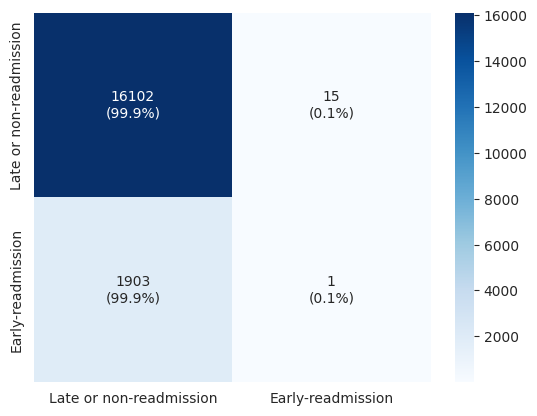

In [35]:
# Visualize confusion matrix with both absolute and percentage values
cm_none = confusion_matrix(y_test, y_test_pred_none)
cm_none_norm = confusion_matrix(y_test, y_test_pred_none, normalize='true')

annotations_none = np.array([
    [f"{val}\n({perc:.1%})" for val, perc in zip(row, norm_row)]
    for row, norm_row in zip(cm_none, cm_none_norm)
])

sns.heatmap(
    cm_none,
    annot=annotations_none,
    cmap='Blues',
    fmt='',
    xticklabels=['Late or non-readmission', 'Early-readmission'],
    yticklabels=['Late or non-readmission', 'Early-readmission']
)

## **3. Optuna Hyper-parameter Tuning | Undersampling**
Hyper-parameter tuning of the model using Optuna, and undersampling with RandomUnderSampler.

### 3.1 Objective & study setup
Preparing the objective function with all hyper-parameters, and creating/loading the Optuna study.

In [36]:
def objective(trial: optuna.Trial) -> float:
    # Hyperparameter search space
    params = {
        "n_estimators": 100,
        "max_depth": trial.suggest_int("max_depth", 4, 30, step=2),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 60, step=2)
    }
    
    # Build pipeline
    pipeline = make_pipeline(
        RandomUnderSampler(random_state=RANDOM_STATE),
        RandomForestClassifier(**params, random_state=RANDOM_STATE)
    )
    
    # Define validation folds
    kf = StratifiedKFold(n_splits=5, shuffle=False)
    
    # Cross validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring=SCORING)

    print("Cross validation scores: {}".format(scores))
    print("Average score: {}".format(scores.mean()))

    return scores.mean()

In [37]:
# Set up study with name and storage
storage = JournalStorage(JournalFileBackend(STUDY_PATH_RUS))

study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(constant_liar=True, seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.INFO)

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/optuna/_experimental.py:31: ExperimentalWarning:

Argument ``constant_liar`` is an experimental feature. The interface can change in the future.

[I 2024-12-30 14:08:32,758] A new study created in Journal with name: Diabetes_130-US


### 3.2 Hyper-parameter tuning
**(CAUTION)** <u>Do not run</u>, unless you already need to find the best parameters. If you already have bound the best model configuration, <u>run the section above</u> _(Objective & study setup)_.

In [38]:
study.optimize(
    objective,
    n_trials=N_TRIALS,
    n_jobs=-1 # Use all available cores
)

[I 2024-12-30 14:08:40,676] Trial 0 finished with value: 0.4727475713628391 and parameters: {'max_depth': 28, 'min_samples_leaf': 40}. Best is trial 0 with value: 0.4727475713628391.


Cross validation scores: [0.47448345 0.47009249 0.47298384 0.4653436  0.48083448]
Average score: 0.4727475713628391


[I 2024-12-30 14:08:40,900] Trial 3 finished with value: 0.47159088188092235 and parameters: {'max_depth': 14, 'min_samples_leaf': 46}. Best is trial 0 with value: 0.4727475713628391.
[I 2024-12-30 14:08:40,982] Trial 10 finished with value: 0.47149101311151026 and parameters: {'max_depth': 16, 'min_samples_leaf': 38}. Best is trial 0 with value: 0.4727475713628391.
[I 2024-12-30 14:08:41,027] Trial 4 finished with value: 0.47149101311151026 and parameters: {'max_depth': 24, 'min_samples_leaf': 38}. Best is trial 0 with value: 0.4727475713628391.
[I 2024-12-30 14:08:41,030] Trial 11 finished with value: 0.47179080006937524 and parameters: {'max_depth': 20, 'min_samples_leaf': 42}. Best is trial 0 with value: 0.4727475713628391.


Cross validation scores: [0.47094472 0.46707634 0.4715738  0.46917448 0.47918507]
Average score: 0.47159088188092235
Cross validation scores: [0.47173073 0.46825407 0.47155181 0.46743181 0.47848664]
Average score: 0.47149101311151026
Cross validation scores: [0.47173073 0.46825407 0.47155181 0.46743181 0.47848664]
Average score: 0.47149101311151026
Cross validation scores: [0.47358608 0.46873833 0.47013943 0.46931205 0.47717811]
Average score: 0.47179080006937524
Cross validation scores: [0.4695679  0.46988189 0.47282979 0.46687551 0.47802875]
Average score: 0.47143676976046833


[I 2024-12-30 14:08:41,111] Trial 5 finished with value: 0.47143676976046833 and parameters: {'max_depth': 24, 'min_samples_leaf': 36}. Best is trial 0 with value: 0.4727475713628391.
[I 2024-12-30 14:08:41,176] Trial 9 finished with value: 0.4724738918840755 and parameters: {'max_depth': 24, 'min_samples_leaf': 28}. Best is trial 0 with value: 0.4727475713628391.
[I 2024-12-30 14:08:41,192] Trial 1 finished with value: 0.47129523164204823 and parameters: {'max_depth': 14, 'min_samples_leaf': 24}. Best is trial 0 with value: 0.4727475713628391.


Cross validation scores: [0.46933243 0.47091154 0.47353178 0.46897367 0.47962003]
Average score: 0.4724738918840755
Cross validation scores: [0.47151671 0.47173959 0.46952927 0.46630944 0.47738115]
Average score: 0.47129523164204823


[I 2024-12-30 14:08:41,797] Trial 8 finished with value: 0.46997492071353963 and parameters: {'max_depth': 26, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.4727475713628391.
[I 2024-12-30 14:08:41,837] Trial 7 finished with value: 0.4697693746867858 and parameters: {'max_depth': 28, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.4727475713628391.


Cross validation scores: [0.46888784 0.46989364 0.46623905 0.46963863 0.47521545]
Average score: 0.46997492071353963
Cross validation scores: [0.4660961  0.47028153 0.46727508 0.46987071 0.47532346]
Average score: 0.4697693746867858


[I 2024-12-30 14:08:42,025] Trial 2 finished with value: 0.4691873979939472 and parameters: {'max_depth': 16, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.4727475713628391.


Cross validation scores: [0.46632838 0.47132292 0.46098139 0.47012619 0.47717811]
Average score: 0.4691873979939472


[I 2024-12-30 14:08:42,811] Trial 6 finished with value: 0.4586628254442714 and parameters: {'max_depth': 30, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.4727475713628391.


Cross validation scores: [0.4538266  0.46026625 0.45585422 0.45964663 0.46372043]
Average score: 0.4586628254442714


[I 2024-12-30 14:08:49,335] Trial 13 finished with value: 0.4727130848702233 and parameters: {'max_depth': 30, 'min_samples_leaf': 30}. Best is trial 0 with value: 0.4727475713628391.
[I 2024-12-30 14:08:49,369] Trial 12 finished with value: 0.47189810976261304 and parameters: {'max_depth': 14, 'min_samples_leaf': 22}. Best is trial 0 with value: 0.4727475713628391.


Cross validation scores: [0.47335477 0.46960738 0.47010172 0.47000917 0.48049238]
Average score: 0.4727130848702233
Cross validation scores: [0.4729644  0.47014357 0.47025754 0.46662933 0.47949571]
Average score: 0.47189810976261304


[I 2024-12-30 14:08:49,611] Trial 14 finished with value: 0.4727130848702233 and parameters: {'max_depth': 18, 'min_samples_leaf': 30}. Best is trial 0 with value: 0.4727475713628391.
[I 2024-12-30 14:08:49,733] Trial 17 finished with value: 0.471623013128212 and parameters: {'max_depth': 12, 'min_samples_leaf': 30}. Best is trial 0 with value: 0.4727475713628391.


Cross validation scores: [0.47335477 0.46960738 0.47010172 0.47000917 0.48049238]
Average score: 0.4727130848702233
Cross validation scores: [0.47321429 0.47039436 0.46909655 0.4648703  0.48053957]
Average score: 0.471623013128212


[I 2024-12-30 14:08:49,817] Trial 16 finished with value: 0.47149898416536196 and parameters: {'max_depth': 28, 'min_samples_leaf': 22}. Best is trial 0 with value: 0.4727475713628391.
[I 2024-12-30 14:08:49,876] Trial 15 finished with value: 0.47022497968027527 and parameters: {'max_depth': 12, 'min_samples_leaf': 20}. Best is trial 0 with value: 0.4727475713628391.
[I 2024-12-30 14:08:49,946] Trial 18 finished with value: 0.4739607766823508 and parameters: {'max_depth': 24, 'min_samples_leaf': 26}. Best is trial 18 with value: 0.4739607766823508.


Cross validation scores: [0.47170852 0.46984689 0.47024088 0.46731551 0.47838311]
Average score: 0.47149898416536196
Cross validation scores: [0.47233422 0.46748856 0.46885552 0.46397404 0.47847255]
Average score: 0.47022497968027527
Cross validation scores: [0.47234163 0.47451175 0.47288345 0.47050561 0.47956144]
Average score: 0.4739607766823508
Cross validation scores: [0.47470827 0.47030838 0.47273973 0.46868626 0.47744989]
Average score: 0.4727785039393213


[I 2024-12-30 14:08:50,014] Trial 21 finished with value: 0.4727785039393213 and parameters: {'max_depth': 8, 'min_samples_leaf': 54}. Best is trial 18 with value: 0.4739607766823508.
[I 2024-12-30 14:08:50,225] Trial 20 finished with value: 0.47276568027310634 and parameters: {'max_depth': 18, 'min_samples_leaf': 60}. Best is trial 18 with value: 0.4739607766823508.


Cross validation scores: [0.47280489 0.46827206 0.47539374 0.46728885 0.48006886]
Average score: 0.47276568027310634
Cross validation scores: [0.47273973 0.46873575 0.47084153 0.46747101 0.47737124]
Average score: 0.4714318517835654


[I 2024-12-30 14:08:50,425] Trial 19 finished with value: 0.4714318517835654 and parameters: {'max_depth': 18, 'min_samples_leaf': 14}. Best is trial 18 with value: 0.4739607766823508.
[I 2024-12-30 14:08:50,686] Trial 22 finished with value: 0.47228557271788596 and parameters: {'max_depth': 22, 'min_samples_leaf': 48}. Best is trial 18 with value: 0.4739607766823508.


Cross validation scores: [0.46901266 0.47202701 0.4720121  0.46882987 0.47954622]
Average score: 0.47228557271788596


[I 2024-12-30 14:08:51,994] Trial 23 finished with value: 0.46999097369746 and parameters: {'max_depth': 22, 'min_samples_leaf': 16}. Best is trial 18 with value: 0.4739607766823508.


Cross validation scores: [0.46984747 0.46662637 0.4681266  0.46749694 0.47785749]
Average score: 0.46999097369746


[I 2024-12-30 14:08:57,182] Trial 25 finished with value: 0.48664376312535323 and parameters: {'max_depth': 4, 'min_samples_leaf': 50}. Best is trial 25 with value: 0.48664376312535323.


Cross validation scores: [0.47421225 0.47778435 0.4899269  0.48352127 0.50777405]
Average score: 0.48664376312535323


[I 2024-12-30 14:08:57,858] Trial 24 finished with value: 0.47173238336277734 and parameters: {'max_depth': 30, 'min_samples_leaf': 34}. Best is trial 25 with value: 0.48664376312535323.
[I 2024-12-30 14:08:58,011] Trial 26 finished with value: 0.47179080006937524 and parameters: {'max_depth': 28, 'min_samples_leaf': 42}. Best is trial 25 with value: 0.48664376312535323.


Cross validation scores: [0.47205343 0.46838588 0.47161555 0.46809308 0.47851398]
Average score: 0.47173238336277734
Cross validation scores: [0.47358608 0.46873833 0.47013943 0.46931205 0.47717811]
Average score: 0.47179080006937524


[I 2024-12-30 14:08:58,103] Trial 27 finished with value: 0.4731071146480371 and parameters: {'max_depth': 30, 'min_samples_leaf': 58}. Best is trial 25 with value: 0.48664376312535323.
[I 2024-12-30 14:08:58,109] Trial 28 finished with value: 0.47179080006937524 and parameters: {'max_depth': 26, 'min_samples_leaf': 42}. Best is trial 25 with value: 0.48664376312535323.
[I 2024-12-30 14:08:58,275] Trial 31 finished with value: 0.4757189912340184 and parameters: {'max_depth': 6, 'min_samples_leaf': 56}. Best is trial 25 with value: 0.48664376312535323.


Cross validation scores: [0.47369143 0.46787881 0.47484707 0.46784655 0.48127171]
Average score: 0.4731071146480371
Cross validation scores: [0.47358608 0.46873833 0.47013943 0.46931205 0.47717811]
Average score: 0.47179080006937524
Cross validation scores: [0.47009901 0.47388614 0.4783408  0.47267102 0.48359798]
Average score: 0.4757189912340184


[I 2024-12-30 14:08:58,468] Trial 32 finished with value: 0.4727785039393213 and parameters: {'max_depth': 8, 'min_samples_leaf': 54}. Best is trial 25 with value: 0.48664376312535323.
[I 2024-12-30 14:08:58,532] Trial 29 finished with value: 0.47173238336277734 and parameters: {'max_depth': 26, 'min_samples_leaf': 34}. Best is trial 25 with value: 0.48664376312535323.


Cross validation scores: [0.47470827 0.47030838 0.47273973 0.46868626 0.47744989]
Average score: 0.4727785039393213
Cross validation scores: [0.47205343 0.46838588 0.47161555 0.46809308 0.47851398]
Average score: 0.47173238336277734


[I 2024-12-30 14:08:58,802] Trial 33 finished with value: 0.4739450227432144 and parameters: {'max_depth': 10, 'min_samples_leaf': 52}. Best is trial 25 with value: 0.48664376312535323.
[I 2024-12-30 14:08:58,808] Trial 30 finished with value: 0.4739607766823508 and parameters: {'max_depth': 22, 'min_samples_leaf': 26}. Best is trial 25 with value: 0.48664376312535323.


Cross validation scores: [0.47848422 0.46846917 0.47348745 0.47011569 0.47916858]
Average score: 0.4739450227432144
Cross validation scores: [0.47234163 0.47451175 0.47288345 0.47050561 0.47956144]
Average score: 0.4739607766823508


[I 2024-12-30 14:08:59,342] Trial 34 finished with value: 0.47276568027310634 and parameters: {'max_depth': 20, 'min_samples_leaf': 60}. Best is trial 25 with value: 0.48664376312535323.


Cross validation scores: [0.47280489 0.46827206 0.47539374 0.46728885 0.48006886]
Average score: 0.47276568027310634


[I 2024-12-30 14:09:00,049] Trial 35 finished with value: 0.4858726393456463 and parameters: {'max_depth': 4, 'min_samples_leaf': 48}. Best is trial 25 with value: 0.48664376312535323.


Cross validation scores: [0.47531564 0.47641777 0.48885126 0.48375313 0.50502541]
Average score: 0.4858726393456463


[I 2024-12-30 14:09:05,501] Trial 36 finished with value: 0.4860508898459579 and parameters: {'max_depth': 4, 'min_samples_leaf': 52}. Best is trial 25 with value: 0.48664376312535323.


Cross validation scores: [0.47405569 0.47820741 0.48828495 0.48342602 0.50628038]
Average score: 0.4860508898459579


[I 2024-12-30 14:09:06,591] Trial 37 finished with value: 0.4778343751528665 and parameters: {'max_depth': 6, 'min_samples_leaf': 46}. Best is trial 25 with value: 0.48664376312535323.


Cross validation scores: [0.4758436  0.47192849 0.4791292  0.47709604 0.48517454]
Average score: 0.4778343751528665


[I 2024-12-30 14:09:06,882] Trial 43 finished with value: 0.48516877162718053 and parameters: {'max_depth': 4, 'min_samples_leaf': 44}. Best is trial 25 with value: 0.48664376312535323.
[I 2024-12-30 14:09:06,919] Trial 38 finished with value: 0.4714086766848274 and parameters: {'max_depth': 8, 'min_samples_leaf': 50}. Best is trial 25 with value: 0.48664376312535323.
[I 2024-12-30 14:09:07,060] Trial 42 finished with value: 0.4757189912340184 and parameters: {'max_depth': 6, 'min_samples_leaf': 56}. Best is trial 25 with value: 0.48664376312535323.


Cross validation scores: [0.4742561  0.47506007 0.48535259 0.48421697 0.50695813]
Average score: 0.48516877162718053
Cross validation scores: [0.47277595 0.46850643 0.46702099 0.46905069 0.47968932]
Average score: 0.4714086766848274
Cross validation scores: [0.47009901 0.47388614 0.4783408  0.47267102 0.48359798]
Average score: 0.4757189912340184
Cross validation scores: [0.47369143 0.46787881 0.47484707 0.46784655 0.48127171]
Average score: 0.4731071146480371
Cross validation scores: [0.4768307  0.47744566 0.47875422 0.47568609 0.48429634]
Average score: 0.4786026030169784


[I 2024-12-30 14:09:07,095] Trial 39 finished with value: 0.4731071146480371 and parameters: {'max_depth': 24, 'min_samples_leaf': 58}. Best is trial 25 with value: 0.48664376312535323.
[I 2024-12-30 14:09:07,103] Trial 41 finished with value: 0.4786026030169784 and parameters: {'max_depth': 6, 'min_samples_leaf': 16}. Best is trial 25 with value: 0.48664376312535323.
[I 2024-12-30 14:09:07,180] Trial 40 finished with value: 0.4731071146480371 and parameters: {'max_depth': 28, 'min_samples_leaf': 58}. Best is trial 25 with value: 0.48664376312535323.


Cross validation scores: [0.47369143 0.46787881 0.47484707 0.46784655 0.48127171]
Average score: 0.4731071146480371


[I 2024-12-30 14:09:08,069] Trial 44 finished with value: 0.4739607766823508 and parameters: {'max_depth': 22, 'min_samples_leaf': 26}. Best is trial 25 with value: 0.48664376312535323.
[I 2024-12-30 14:09:08,163] Trial 45 finished with value: 0.4724738918840755 and parameters: {'max_depth': 22, 'min_samples_leaf': 28}. Best is trial 25 with value: 0.48664376312535323.


Cross validation scores: [0.47234163 0.47451175 0.47288345 0.47050561 0.47956144]
Average score: 0.4739607766823508
Cross validation scores: [0.46933243 0.47091154 0.47353178 0.46897367 0.47962003]
Average score: 0.4724738918840755


[I 2024-12-30 14:09:08,319] Trial 47 finished with value: 0.4858726393456463 and parameters: {'max_depth': 4, 'min_samples_leaf': 48}. Best is trial 25 with value: 0.48664376312535323.
[I 2024-12-30 14:09:08,499] Trial 46 finished with value: 0.47149101311151026 and parameters: {'max_depth': 20, 'min_samples_leaf': 38}. Best is trial 25 with value: 0.48664376312535323.


Cross validation scores: [0.47531564 0.47641777 0.48885126 0.48375313 0.50502541]
Average score: 0.4858726393456463
Cross validation scores: [0.47173073 0.46825407 0.47155181 0.46743181 0.47848664]
Average score: 0.47149101311151026


[I 2024-12-30 14:09:13,964] Trial 48 finished with value: 0.48664376312535323 and parameters: {'max_depth': 4, 'min_samples_leaf': 50}. Best is trial 25 with value: 0.48664376312535323.


Cross validation scores: [0.47421225 0.47778435 0.4899269  0.48352127 0.50777405]
Average score: 0.48664376312535323


[I 2024-12-30 14:09:15,293] Trial 50 finished with value: 0.48516877162718053 and parameters: {'max_depth': 4, 'min_samples_leaf': 44}. Best is trial 25 with value: 0.48664376312535323.
[I 2024-12-30 14:09:15,334] Trial 51 finished with value: 0.4847995146796905 and parameters: {'max_depth': 4, 'min_samples_leaf': 40}. Best is trial 25 with value: 0.48664376312535323.


Cross validation scores: [0.4742561  0.47506007 0.48535259 0.48421697 0.50695813]
Average score: 0.48516877162718053
Cross validation scores: [0.47363241 0.47713488 0.48310078 0.48615147 0.50397804]
Average score: 0.4847995146796905


[I 2024-12-30 14:09:15,546] Trial 53 finished with value: 0.48533936718856385 and parameters: {'max_depth': 4, 'min_samples_leaf': 6}. Best is trial 25 with value: 0.48664376312535323.
[I 2024-12-30 14:09:15,576] Trial 49 finished with value: 0.472456765379419 and parameters: {'max_depth': 10, 'min_samples_leaf': 46}. Best is trial 25 with value: 0.48664376312535323.


Cross validation scores: [0.47703985 0.47797284 0.48858591 0.48650951 0.49658872]
Average score: 0.48533936718856385
Cross validation scores: [0.47291667 0.47013552 0.47191811 0.46909148 0.47822204]
Average score: 0.472456765379419


[I 2024-12-30 14:09:15,796] Trial 52 finished with value: 0.47607897256134535 and parameters: {'max_depth': 6, 'min_samples_leaf': 52}. Best is trial 25 with value: 0.48664376312535323.


Cross validation scores: [0.47294877 0.4721484  0.47717926 0.47485926 0.48325918]
Average score: 0.47607897256134535


[I 2024-12-30 14:09:16,031] Trial 54 finished with value: 0.47939262870337923 and parameters: {'max_depth': 6, 'min_samples_leaf': 12}. Best is trial 25 with value: 0.48664376312535323.


Cross validation scores: [0.476141   0.47831452 0.48000873 0.47649124 0.48600766]
Average score: 0.47939262870337923


[I 2024-12-30 14:09:16,284] Trial 55 finished with value: 0.4708709498481025 and parameters: {'max_depth': 10, 'min_samples_leaf': 44}. Best is trial 25 with value: 0.48664376312535323.


Cross validation scores: [0.47200215 0.46662113 0.46842239 0.46919558 0.4781135 ]
Average score: 0.4708709498481025


[I 2024-12-30 14:09:16,708] Trial 58 finished with value: 0.4858726393456463 and parameters: {'max_depth': 4, 'min_samples_leaf': 48}. Best is trial 25 with value: 0.48664376312535323.


Cross validation scores: [0.47531564 0.47641777 0.48885126 0.48375313 0.50502541]
Average score: 0.4858726393456463


[I 2024-12-30 14:09:16,932] Trial 59 finished with value: 0.4858726393456463 and parameters: {'max_depth': 4, 'min_samples_leaf': 48}. Best is trial 25 with value: 0.48664376312535323.
[I 2024-12-30 14:09:16,983] Trial 56 finished with value: 0.4714086766848274 and parameters: {'max_depth': 8, 'min_samples_leaf': 50}. Best is trial 25 with value: 0.48664376312535323.


Cross validation scores: [0.47531564 0.47641777 0.48885126 0.48375313 0.50502541]
Average score: 0.4858726393456463
Cross validation scores: [0.47277595 0.46850643 0.46702099 0.46905069 0.47968932]
Average score: 0.4714086766848274


[I 2024-12-30 14:09:17,710] Trial 57 finished with value: 0.4715342326125967 and parameters: {'max_depth': 12, 'min_samples_leaf': 18}. Best is trial 25 with value: 0.48664376312535323.


Cross validation scores: [0.47083333 0.46970671 0.46938724 0.4694932  0.47825069]
Average score: 0.4715342326125967


[I 2024-12-30 14:09:22,719] Trial 60 finished with value: 0.4714086766848274 and parameters: {'max_depth': 8, 'min_samples_leaf': 50}. Best is trial 25 with value: 0.48664376312535323.


Cross validation scores: [0.47277595 0.46850643 0.46702099 0.46905069 0.47968932]
Average score: 0.4714086766848274


[I 2024-12-30 14:09:23,901] Trial 62 finished with value: 0.48516877162718053 and parameters: {'max_depth': 4, 'min_samples_leaf': 44}. Best is trial 25 with value: 0.48664376312535323.
[I 2024-12-30 14:09:23,971] Trial 61 finished with value: 0.4860508898459579 and parameters: {'max_depth': 4, 'min_samples_leaf': 52}. Best is trial 25 with value: 0.48664376312535323.


Cross validation scores: [0.4742561  0.47506007 0.48535259 0.48421697 0.50695813]
Average score: 0.48516877162718053
Cross validation scores: [0.47405569 0.47820741 0.48828495 0.48342602 0.50628038]
Average score: 0.4860508898459579


[I 2024-12-30 14:09:24,287] Trial 64 finished with value: 0.4847995146796905 and parameters: {'max_depth': 4, 'min_samples_leaf': 40}. Best is trial 25 with value: 0.48664376312535323.
[I 2024-12-30 14:09:24,427] Trial 63 finished with value: 0.4761453529744292 and parameters: {'max_depth': 6, 'min_samples_leaf': 54}. Best is trial 25 with value: 0.48664376312535323.


Cross validation scores: [0.47363241 0.47713488 0.48310078 0.48615147 0.50397804]
Average score: 0.4847995146796905
Cross validation scores: [0.47206996 0.47404187 0.47744566 0.47409052 0.48307875]
Average score: 0.4761453529744292


[I 2024-12-30 14:09:24,718] Trial 67 finished with value: 0.48533936718856385 and parameters: {'max_depth': 4, 'min_samples_leaf': 6}. Best is trial 25 with value: 0.48664376312535323.
[I 2024-12-30 14:09:24,762] Trial 65 finished with value: 0.47844014699486365 and parameters: {'max_depth': 6, 'min_samples_leaf': 2}. Best is trial 25 with value: 0.48664376312535323.


Cross validation scores: [0.47703985 0.47797284 0.48858591 0.48650951 0.49658872]
Average score: 0.48533936718856385
Cross validation scores: [0.47697699 0.47680009 0.47770987 0.47726494 0.48344884]
Average score: 0.47844014699486365


[I 2024-12-30 14:09:25,501] Trial 66 finished with value: 0.473942902940109 and parameters: {'max_depth': 8, 'min_samples_leaf': 34}. Best is trial 25 with value: 0.48664376312535323.


Cross validation scores: [0.47398376 0.47186493 0.47278633 0.47133672 0.47974278]
Average score: 0.473942902940109


[I 2024-12-30 14:09:26,078] Trial 69 finished with value: 0.4771830412636426 and parameters: {'max_depth': 6, 'min_samples_leaf': 48}. Best is trial 25 with value: 0.48664376312535323.
[I 2024-12-30 14:09:26,218] Trial 68 finished with value: 0.4729892505584412 and parameters: {'max_depth': 16, 'min_samples_leaf': 50}. Best is trial 25 with value: 0.48664376312535323.


Cross validation scores: [0.47580253 0.47359165 0.47609691 0.4740216  0.48640251]
Average score: 0.4771830412636426
Cross validation scores: [0.47363908 0.47058848 0.47395498 0.46645971 0.480304  ]
Average score: 0.4729892505584412
Cross validation scores: [0.47591601 0.47099888 0.47351853 0.46823554 0.47761097]
Average score: 0.47325598557818765


[I 2024-12-30 14:09:26,267] Trial 70 finished with value: 0.47325598557818765 and parameters: {'max_depth': 10, 'min_samples_leaf': 56}. Best is trial 25 with value: 0.48664376312535323.
[I 2024-12-30 14:09:26,393] Trial 71 finished with value: 0.4858726393456463 and parameters: {'max_depth': 4, 'min_samples_leaf': 48}. Best is trial 25 with value: 0.48664376312535323.


Cross validation scores: [0.47531564 0.47641777 0.48885126 0.48375313 0.50502541]
Average score: 0.4858726393456463


[I 2024-12-30 14:09:31,557] Trial 72 finished with value: 0.4858726393456463 and parameters: {'max_depth': 4, 'min_samples_leaf': 48}. Best is trial 25 with value: 0.48664376312535323.


Cross validation scores: [0.47531564 0.47641777 0.48885126 0.48375313 0.50502541]
Average score: 0.4858726393456463


[I 2024-12-30 14:09:32,996] Trial 74 finished with value: 0.4860508898459579 and parameters: {'max_depth': 4, 'min_samples_leaf': 52}. Best is trial 25 with value: 0.48664376312535323.


Cross validation scores: [0.47405569 0.47820741 0.48828495 0.48342602 0.50628038]
Average score: 0.4860508898459579


[I 2024-12-30 14:09:33,224] Trial 73 finished with value: 0.47607897256134535 and parameters: {'max_depth': 6, 'min_samples_leaf': 52}. Best is trial 25 with value: 0.48664376312535323.


Cross validation scores: [0.47294877 0.4721484  0.47717926 0.47485926 0.48325918]
Average score: 0.47607897256134535


[I 2024-12-30 14:09:33,567] Trial 78 finished with value: 0.48414501437493734 and parameters: {'max_depth': 4, 'min_samples_leaf': 36}. Best is trial 25 with value: 0.48664376312535323.
[I 2024-12-30 14:09:33,629] Trial 75 finished with value: 0.4727785039393213 and parameters: {'max_depth': 8, 'min_samples_leaf': 54}. Best is trial 25 with value: 0.48664376312535323.


Cross validation scores: [0.47478229 0.4778399  0.48263576 0.48343098 0.50203613]
Average score: 0.48414501437493734
Cross validation scores: [0.47470827 0.47030838 0.47273973 0.46868626 0.47744989]
Average score: 0.4727785039393213


[I 2024-12-30 14:09:33,989] Trial 77 finished with value: 0.4778343751528665 and parameters: {'max_depth': 6, 'min_samples_leaf': 46}. Best is trial 25 with value: 0.48664376312535323.
[I 2024-12-30 14:09:34,074] Trial 76 finished with value: 0.4716687353522528 and parameters: {'max_depth': 14, 'min_samples_leaf': 42}. Best is trial 25 with value: 0.48664376312535323.


Cross validation scores: [0.4758436  0.47192849 0.4791292  0.47709604 0.48517454]
Average score: 0.4778343751528665
Cross validation scores: [0.47372867 0.46881645 0.46999587 0.46862457 0.47717811]
Average score: 0.4716687353522528


[I 2024-12-30 14:09:34,519] Trial 79 finished with value: 0.48522855416200417 and parameters: {'max_depth': 4, 'min_samples_leaf': 56}. Best is trial 25 with value: 0.48664376312535323.


Cross validation scores: [0.47347004 0.47845192 0.48620393 0.48375313 0.50426375]
Average score: 0.48522855416200417


[I 2024-12-30 14:09:35,351] Trial 82 finished with value: 0.4858726393456463 and parameters: {'max_depth': 4, 'min_samples_leaf': 48}. Best is trial 25 with value: 0.48664376312535323.


Cross validation scores: [0.47531564 0.47641777 0.48885126 0.48375313 0.50502541]
Average score: 0.4858726393456463


[I 2024-12-30 14:09:35,588] Trial 83 finished with value: 0.4860508898459579 and parameters: {'max_depth': 4, 'min_samples_leaf': 52}. Best is trial 25 with value: 0.48664376312535323.
[I 2024-12-30 14:09:35,650] Trial 81 finished with value: 0.4778343751528665 and parameters: {'max_depth': 6, 'min_samples_leaf': 46}. Best is trial 25 with value: 0.48664376312535323.


Cross validation scores: [0.47405569 0.47820741 0.48828495 0.48342602 0.50628038]
Average score: 0.4860508898459579
Cross validation scores: [0.4758436  0.47192849 0.4791292  0.47709604 0.48517454]
Average score: 0.4778343751528665


[I 2024-12-30 14:09:35,839] Trial 80 finished with value: 0.47214007072469777 and parameters: {'max_depth': 8, 'min_samples_leaf': 60}. Best is trial 25 with value: 0.48664376312535323.


Cross validation scores: [0.47498001 0.46911121 0.47045146 0.46744448 0.4787132 ]
Average score: 0.47214007072469777


[I 2024-12-30 14:09:41,153] Trial 84 finished with value: 0.47613492983757605 and parameters: {'max_depth': 6, 'min_samples_leaf': 50}. Best is trial 25 with value: 0.48664376312535323.


Cross validation scores: [0.47355779 0.47222683 0.47577313 0.47516868 0.48394822]
Average score: 0.47613492983757605


[I 2024-12-30 14:09:42,088] Trial 85 finished with value: 0.4852003308888134 and parameters: {'max_depth': 4, 'min_samples_leaf': 54}. Best is trial 25 with value: 0.48664376312535323.
[I 2024-12-30 14:09:42,157] Trial 86 finished with value: 0.4860508898459579 and parameters: {'max_depth': 4, 'min_samples_leaf': 52}. Best is trial 25 with value: 0.48664376312535323.


Cross validation scores: [0.47345683 0.47856737 0.48658086 0.48305379 0.5043428 ]
Average score: 0.4852003308888134
Cross validation scores: [0.47405569 0.47820741 0.48828495 0.48342602 0.50628038]
Average score: 0.4860508898459579


[I 2024-12-30 14:09:42,889] Trial 88 finished with value: 0.4765705408135955 and parameters: {'max_depth': 6, 'min_samples_leaf': 58}. Best is trial 25 with value: 0.48664376312535323.


Cross validation scores: [0.47294877 0.47470439 0.47701466 0.47410873 0.48407615]
Average score: 0.4765705408135955
Cross validation scores: [0.4758436  0.47192849 0.4791292  0.47709604 0.48517454]
Average score: 0.4778343751528665


[I 2024-12-30 14:09:43,091] Trial 87 finished with value: 0.4778343751528665 and parameters: {'max_depth': 6, 'min_samples_leaf': 46}. Best is trial 25 with value: 0.48664376312535323.
[I 2024-12-30 14:09:43,130] Trial 89 finished with value: 0.4860508898459579 and parameters: {'max_depth': 4, 'min_samples_leaf': 52}. Best is trial 25 with value: 0.48664376312535323.


Cross validation scores: [0.47405569 0.47820741 0.48828495 0.48342602 0.50628038]
Average score: 0.4860508898459579


[I 2024-12-30 14:09:43,565] Trial 91 finished with value: 0.48664376312535323 and parameters: {'max_depth': 4, 'min_samples_leaf': 50}. Best is trial 25 with value: 0.48664376312535323.
[I 2024-12-30 14:09:43,629] Trial 90 finished with value: 0.4725520022748938 and parameters: {'max_depth': 8, 'min_samples_leaf': 56}. Best is trial 25 with value: 0.48664376312535323.
[I 2024-12-30 14:09:43,683] Trial 92 finished with value: 0.4858726393456463 and parameters: {'max_depth': 4, 'min_samples_leaf': 48}. Best is trial 25 with value: 0.48664376312535323.


Cross validation scores: [0.47421225 0.47778435 0.4899269  0.48352127 0.50777405]
Average score: 0.48664376312535323
Cross validation scores: [0.4727147  0.47037853 0.47528148 0.46560889 0.47877641]
Average score: 0.4725520022748938
Cross validation scores: [0.47531564 0.47641777 0.48885126 0.48375313 0.50502541]
Average score: 0.4858726393456463


[I 2024-12-30 14:09:43,925] Trial 94 finished with value: 0.4852003308888134 and parameters: {'max_depth': 4, 'min_samples_leaf': 54}. Best is trial 25 with value: 0.48664376312535323.
[I 2024-12-30 14:09:43,997] Trial 93 finished with value: 0.47607897256134535 and parameters: {'max_depth': 6, 'min_samples_leaf': 52}. Best is trial 25 with value: 0.48664376312535323.


Cross validation scores: [0.47345683 0.47856737 0.48658086 0.48305379 0.5043428 ]
Average score: 0.4852003308888134
Cross validation scores: [0.47294877 0.4721484  0.47717926 0.47485926 0.48325918]
Average score: 0.47607897256134535


[I 2024-12-30 14:09:44,131] Trial 95 finished with value: 0.47607897256134535 and parameters: {'max_depth': 6, 'min_samples_leaf': 52}. Best is trial 25 with value: 0.48664376312535323.


Cross validation scores: [0.47294877 0.4721484  0.47717926 0.47485926 0.48325918]
Average score: 0.47607897256134535


[I 2024-12-30 14:09:45,163] Trial 96 finished with value: 0.48664376312535323 and parameters: {'max_depth': 4, 'min_samples_leaf': 50}. Best is trial 25 with value: 0.48664376312535323.
[I 2024-12-30 14:09:45,262] Trial 97 finished with value: 0.48516877162718053 and parameters: {'max_depth': 4, 'min_samples_leaf': 44}. Best is trial 25 with value: 0.48664376312535323.
[I 2024-12-30 14:09:45,336] Trial 99 finished with value: 0.48529569032382697 and parameters: {'max_depth': 4, 'min_samples_leaf': 58}. Best is trial 25 with value: 0.48664376312535323.


Cross validation scores: [0.47421225 0.47778435 0.4899269  0.48352127 0.50777405]
Average score: 0.48664376312535323
Cross validation scores: [0.4742561  0.47506007 0.48535259 0.48421697 0.50695813]
Average score: 0.48516877162718053
Cross validation scores: [0.47382025 0.48058155 0.48627668 0.48352127 0.5022787 ]
Average score: 0.48529569032382697


[I 2024-12-30 14:09:45,382] Trial 98 finished with value: 0.47607897256134535 and parameters: {'max_depth': 6, 'min_samples_leaf': 52}. Best is trial 25 with value: 0.48664376312535323.


Cross validation scores: [0.47294877 0.4721484  0.47717926 0.47485926 0.48325918]
Average score: 0.47607897256134535


In [39]:
print('Best Trial: {}'.format(study.best_trial.number))
print('Best Parameters: {}'.format(study.best_params))
print('Best Value: {}'.format(study.best_value))

Best Trial: 25
Best Parameters: {'max_depth': 4, 'min_samples_leaf': 50}
Best Value: 0.48664376312535323


### 3.3 Optuna Visualizations
Visualizing hyper-parameter tuning results obtained by running Optuna.

In [40]:
optuna.visualization.plot_optimization_history(study)

In [41]:
optuna.visualization.plot_slice(study)

In [42]:
optuna.visualization.plot_param_importances(study)

In [43]:
optuna.visualization.plot_parallel_coordinate(study)

In [44]:
optuna.visualization.plot_contour(study)

In [45]:
optuna.visualization.plot_timeline(study)

### 3.4 Fitting Best Model
Fitting the final model using the best hyper-parameters found by Optuna.

In [46]:
# Fit best model on the training set
best_params = study.best_params

pipeline_rus = make_pipeline(
    RandomUnderSampler(random_state=RANDOM_STATE),
    RandomForestClassifier(**best_params, random_state=RANDOM_STATE)
)

pipeline_rus.fit(X_train, y_train)

Pipeline(steps=[('randomundersampler', RandomUnderSampler(random_state=38)),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=4, min_samples_leaf=50,
                                        random_state=38))])

In [47]:
# Predictions
y_train_pred_rus = pipeline_rus.predict(X_train)
y_test_pred_rus = pipeline_rus.predict(X_test)

In [48]:
ac_train_rus = accuracy_score(y_train, y_train_pred_rus)
ac_test_rus = accuracy_score(y_test, y_test_pred_rus)

print('Train accuracy: ', ac_train_rus)
print('Test accuracy: ', ac_test_rus)

Train accuracy:  0.6238584474885844
Test accuracy:  0.6204983075301038


In [49]:
# Visualize precision, recall, F1-score
print(classification_report(
    y_test, y_test_pred_rus,
    target_names=['Late or non-readmission', 'Early-readmission']
))

                         precision    recall  f1-score   support

Late or non-readmission       0.92      0.63      0.75     16117
      Early-readmission       0.15      0.56      0.24      1904

               accuracy                           0.62     18021
              macro avg       0.54      0.59      0.49     18021
           weighted avg       0.84      0.62      0.69     18021



In [50]:
# Compute precision, recall, F1-score, ROC-AUC-score, and accuracy
recall_rus = recall_score(y_test, y_test_pred_rus, average='macro')
precision_rus = precision_score(y_test, y_test_pred_rus, average='macro')
f1_rus = f1_score(y_test, y_test_pred_rus, average='macro')
roc_auc_rus = roc_auc_score(y_test, y_test_pred_rus, average='macro')
accuracy_rus = accuracy_score(y_test, y_test_pred_rus)

<Axes: >

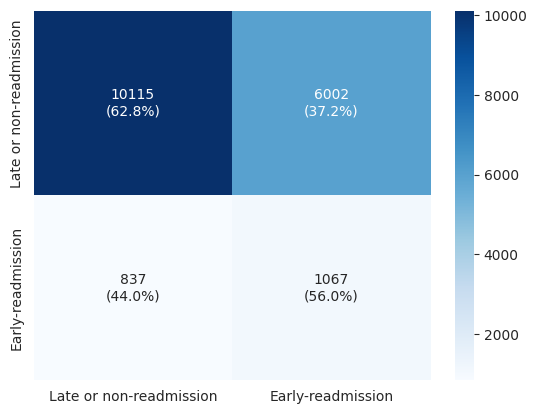

In [51]:
# Visualize confusion matrix with both absolute and percentage values
cm_rus = confusion_matrix(y_test, y_test_pred_rus)
cm_rus_norm = confusion_matrix(y_test, y_test_pred_rus, normalize='true')

annotations_rus = np.array([
    [f"{val}\n({perc:.1%})" for val, perc in zip(row, norm_row)]
    for row, norm_row in zip(cm_rus, cm_rus_norm)
])

sns.heatmap(
    cm_rus,
    annot=annotations_rus,
    cmap='Blues',
    fmt='',
    xticklabels=['Late or non-readmission', 'Early-readmission'],
    yticklabels=['Late or non-readmission', 'Early-readmission']
)

## **4. Optuna Hyper-parameter Tuning | SMOTE**
Hyper-parameter tuning of the model using Optuna, and oversampling with SMOTE.

### 4.1 Objective & study setup
Preparing the objective function with all hyper-parameters, and creating/loading the Optuna study.

In [52]:
def objective(trial: optuna.Trial) -> float:
    # Hyperparameter search space
    params = {
        "n_estimators": 100,
        "max_depth": trial.suggest_int("max_depth", 14, 40, step=2),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 16, 100, step=2)
    }
    
    # Build pipeline
    pipeline = make_pipeline(
        SMOTE(random_state=RANDOM_STATE),
        RandomForestClassifier(**params, random_state=RANDOM_STATE)
    )
    
    # Define validation folds
    kf = StratifiedKFold(n_splits=5, shuffle=False)
    
    # Cross validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring=SCORING)

    print("Cross validation scores: {}".format(scores))
    print("Average score: {}".format(scores.mean()))

    return scores.mean()

In [53]:
# Set up study with name and storage
storage = JournalStorage(JournalFileBackend(STUDY_PATH_SMOTE))

study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(constant_liar=True, seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.INFO)

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/optuna/_experimental.py:31: ExperimentalWarning:

Argument ``constant_liar`` is an experimental feature. The interface can change in the future.

[I 2024-12-30 14:09:46,128] A new study created in Journal with name: Diabetes_130-US


### 4.2 Hyper-parameter tuning
**(CAUTION)** <u>Do not run</u>, unless you already need to find the best parameters. If you already have bound the best model configuration, <u>run the section above</u> _(Objective & study setup)_.

In [54]:
study.optimize(
    objective,
    n_trials=N_TRIALS,
    n_jobs=-1 # Use all available cores
)

[I 2024-12-30 14:10:10,430] Trial 8 finished with value: 0.5364033136082651 and parameters: {'max_depth': 14, 'min_samples_leaf': 66}. Best is trial 8 with value: 0.5364033136082651.


Cross validation scores: [0.53044048 0.52846096 0.53870897 0.53791164 0.54649453]
Average score: 0.5364033136082651


[I 2024-12-30 14:10:10,881] Trial 7 finished with value: 0.5368906404894099 and parameters: {'max_depth': 16, 'min_samples_leaf': 80}. Best is trial 7 with value: 0.5368906404894099.
[I 2024-12-30 14:10:11,035] Trial 6 finished with value: 0.5397132016825412 and parameters: {'max_depth': 26, 'min_samples_leaf': 98}. Best is trial 0 with value: 0.539804361220507.
[I 2024-12-30 14:10:11,036] Trial 0 finished with value: 0.539804361220507 and parameters: {'max_depth': 34, 'min_samples_leaf': 98}. Best is trial 0 with value: 0.539804361220507.


Cross validation scores: [0.53077789 0.53127718 0.54227879 0.53114413 0.54897522]
Average score: 0.5368906404894099
Cross validation scores: [0.53252671 0.53679325 0.54398025 0.53666252 0.54860328]
Average score: 0.5397132016825412
Cross validation scores: [0.53244611 0.5364641  0.54398025 0.5367451  0.54938624]
Average score: 0.539804361220507


[I 2024-12-30 14:10:11,203] Trial 5 finished with value: 0.5389809336329459 and parameters: {'max_depth': 40, 'min_samples_leaf': 100}. Best is trial 0 with value: 0.539804361220507.
[I 2024-12-30 14:10:11,268] Trial 3 finished with value: 0.5413564933824566 and parameters: {'max_depth': 36, 'min_samples_leaf': 92}. Best is trial 3 with value: 0.5413564933824566.
[I 2024-12-30 14:10:11,304] Trial 4 finished with value: 0.5413564933824566 and parameters: {'max_depth': 34, 'min_samples_leaf': 92}. Best is trial 3 with value: 0.5413564933824566.


Cross validation scores: [0.53285964 0.53287706 0.54514553 0.53597377 0.54804866]
Average score: 0.5389809336329459
Cross validation scores: [0.53500965 0.53442583 0.54780584 0.54127186 0.54826929]
Average score: 0.5413564933824566
Cross validation scores: [0.53500965 0.53442583 0.54780584 0.54127186 0.54826929]
Average score: 0.5413564933824566


[I 2024-12-30 14:10:11,581] Trial 11 finished with value: 0.5361000022449903 and parameters: {'max_depth': 14, 'min_samples_leaf': 32}. Best is trial 3 with value: 0.5413564933824566.


Cross validation scores: [0.53570102 0.52854637 0.53664823 0.5341126  0.5454918 ]
Average score: 0.5361000022449903


[I 2024-12-30 14:10:11,828] Trial 1 finished with value: 0.5378220918653698 and parameters: {'max_depth': 36, 'min_samples_leaf': 74}. Best is trial 3 with value: 0.5413564933824566.


Cross validation scores: [0.53163905 0.53316953 0.54447051 0.53278374 0.54704763]
Average score: 0.5378220918653698


[I 2024-12-30 14:10:12,690] Trial 9 finished with value: 0.536961421739824 and parameters: {'max_depth': 22, 'min_samples_leaf': 50}. Best is trial 3 with value: 0.5413564933824566.
[I 2024-12-30 14:10:12,741] Trial 10 finished with value: 0.536961421739824 and parameters: {'max_depth': 22, 'min_samples_leaf': 50}. Best is trial 3 with value: 0.5413564933824566.


Cross validation scores: [0.52896337 0.53395844 0.54458786 0.53370359 0.54359384]
Average score: 0.536961421739824
Cross validation scores: [0.52896337 0.53395844 0.54458786 0.53370359 0.54359384]
Average score: 0.536961421739824
Cross validation scores: [0.53101745 0.53313489 0.54237237 0.53390382 0.54084752]
Average score: 0.5362552115486398


[I 2024-12-30 14:10:12,902] Trial 2 finished with value: 0.5362552115486398 and parameters: {'max_depth': 20, 'min_samples_leaf': 46}. Best is trial 3 with value: 0.5413564933824566.
[I 2024-12-30 14:10:34,978] Trial 15 finished with value: 0.537345271815177 and parameters: {'max_depth': 16, 'min_samples_leaf': 86}. Best is trial 3 with value: 0.5413564933824566.


Cross validation scores: [0.53150057 0.53004126 0.54130742 0.53442177 0.54945534]
Average score: 0.537345271815177


[I 2024-12-30 14:10:35,434] Trial 13 finished with value: 0.5384003672984424 and parameters: {'max_depth': 40, 'min_samples_leaf': 90}. Best is trial 3 with value: 0.5413564933824566.
[I 2024-12-30 14:10:35,541] Trial 12 finished with value: 0.536926430555815 and parameters: {'max_depth': 16, 'min_samples_leaf': 52}. Best is trial 3 with value: 0.5413564933824566.


Cross validation scores: [0.53314685 0.53325672 0.54226362 0.53748969 0.54584496]
Average score: 0.5384003672984424
Cross validation scores: [0.53050395 0.53071448 0.5397498  0.53857395 0.54508997]
Average score: 0.536926430555815


[I 2024-12-30 14:10:35,865] Trial 16 finished with value: 0.5373062115052117 and parameters: {'max_depth': 14, 'min_samples_leaf': 38}. Best is trial 3 with value: 0.5413564933824566.


Cross validation scores: [0.53489593 0.52905622 0.54226584 0.53321309 0.54709998]
Average score: 0.5373062115052117


[I 2024-12-30 14:10:36,232] Trial 14 finished with value: 0.5379661429535958 and parameters: {'max_depth': 24, 'min_samples_leaf': 80}. Best is trial 3 with value: 0.5413564933824566.
[I 2024-12-30 14:10:36,320] Trial 18 finished with value: 0.5378220918653698 and parameters: {'max_depth': 38, 'min_samples_leaf': 74}. Best is trial 3 with value: 0.5413564933824566.


Cross validation scores: [0.53099191 0.53613856 0.54259711 0.53382126 0.54628187]
Average score: 0.5379661429535958
Cross validation scores: [0.53163905 0.53316953 0.54447051 0.53278374 0.54704763]
Average score: 0.5378220918653698


[I 2024-12-30 14:10:36,822] Trial 19 finished with value: 0.5382209636271722 and parameters: {'max_depth': 28, 'min_samples_leaf': 70}. Best is trial 3 with value: 0.5413564933824566.


Cross validation scores: [0.5324912  0.53720492 0.54248762 0.53844219 0.54047888]
Average score: 0.5382209636271722


[I 2024-12-30 14:10:37,327] Trial 23 finished with value: 0.5393098000800572 and parameters: {'max_depth': 36, 'min_samples_leaf': 88}. Best is trial 3 with value: 0.5413564933824566.


Cross validation scores: [0.53439393 0.53358588 0.54551077 0.53640945 0.54664897]
Average score: 0.5393098000800572


[I 2024-12-30 14:10:38,178] Trial 22 finished with value: 0.5374171362106047 and parameters: {'max_depth': 34, 'min_samples_leaf': 62}. Best is trial 3 with value: 0.5413564933824566.


Cross validation scores: [0.52831002 0.53117812 0.54312633 0.53820503 0.54626618]
Average score: 0.5374171362106047


[I 2024-12-30 14:10:38,669] Trial 17 finished with value: 0.5345140297514254 and parameters: {'max_depth': 30, 'min_samples_leaf': 30}. Best is trial 3 with value: 0.5413564933824566.


Cross validation scores: [0.52770032 0.52452665 0.54437635 0.53755453 0.53841229]
Average score: 0.5345140297514254


[I 2024-12-30 14:10:39,009] Trial 20 finished with value: 0.5353031389046471 and parameters: {'max_depth': 20, 'min_samples_leaf': 32}. Best is trial 3 with value: 0.5413564933824566.


Cross validation scores: [0.52794085 0.53006486 0.54616361 0.53484114 0.53750524]
Average score: 0.5353031389046471


[I 2024-12-30 14:10:42,098] Trial 21 finished with value: 0.523862476931719 and parameters: {'max_depth': 32, 'min_samples_leaf': 16}. Best is trial 3 with value: 0.5413564933824566.


Cross validation scores: [0.51562652 0.52024818 0.53128686 0.52457536 0.52757548]
Average score: 0.523862476931719


[I 2024-12-30 14:10:59,626] Trial 24 finished with value: 0.5413564933824566 and parameters: {'max_depth': 30, 'min_samples_leaf': 92}. Best is trial 3 with value: 0.5413564933824566.


Cross validation scores: [0.53500965 0.53442583 0.54780584 0.54127186 0.54826929]
Average score: 0.5413564933824566


[I 2024-12-30 14:11:00,539] Trial 25 finished with value: 0.5396990310288932 and parameters: {'max_depth': 32, 'min_samples_leaf': 82}. Best is trial 3 with value: 0.5413564933824566.


Cross validation scores: [0.53498822 0.53548938 0.54472614 0.53755283 0.54573859]
Average score: 0.5396990310288932


[I 2024-12-30 14:11:00,814] Trial 27 finished with value: 0.5383594110978163 and parameters: {'max_depth': 28, 'min_samples_leaf': 76}. Best is trial 3 with value: 0.5413564933824566.
[I 2024-12-30 14:11:00,870] Trial 29 finished with value: 0.5382861338715282 and parameters: {'max_depth': 36, 'min_samples_leaf': 96}. Best is trial 3 with value: 0.5413564933824566.


Cross validation scores: [0.53281226 0.532934   0.54336598 0.53877737 0.54390744]
Average score: 0.5383594110978163
Cross validation scores: [0.53364289 0.53350062 0.5384768  0.54072399 0.54508637]
Average score: 0.5382861338715282


[I 2024-12-30 14:11:01,043] Trial 28 finished with value: 0.540357387646899 and parameters: {'max_depth': 34, 'min_samples_leaf': 94}. Best is trial 3 with value: 0.5413564933824566.


Cross validation scores: [0.53351887 0.53617146 0.5435181  0.53646029 0.55211821]
Average score: 0.540357387646899


[I 2024-12-30 14:11:02,004] Trial 26 finished with value: 0.5380757108366987 and parameters: {'max_depth': 38, 'min_samples_leaf': 58}. Best is trial 3 with value: 0.5413564933824566.
[I 2024-12-30 14:11:02,114] Trial 31 finished with value: 0.5388481164850353 and parameters: {'max_depth': 32, 'min_samples_leaf': 86}. Best is trial 3 with value: 0.5413564933824566.


Cross validation scores: [0.53105832 0.53437154 0.54387732 0.53999731 0.54107405]
Average score: 0.5380757108366987
Cross validation scores: [0.53099191 0.53871233 0.54268839 0.53743394 0.54441402]
Average score: 0.5388481164850353


[I 2024-12-30 14:11:02,258] Trial 32 finished with value: 0.5389809336329459 and parameters: {'max_depth': 34, 'min_samples_leaf': 100}. Best is trial 3 with value: 0.5413564933824566.


Cross validation scores: [0.53285964 0.53287706 0.54514553 0.53597377 0.54804866]
Average score: 0.5389809336329459


[I 2024-12-30 14:11:02,616] Trial 30 finished with value: 0.5360194381910508 and parameters: {'max_depth': 38, 'min_samples_leaf': 66}. Best is trial 3 with value: 0.5413564933824566.


Cross validation scores: [0.53096403 0.52965227 0.54271515 0.53335026 0.54341548]
Average score: 0.5360194381910508


[I 2024-12-30 14:11:03,202] Trial 33 finished with value: 0.540357387646899 and parameters: {'max_depth': 30, 'min_samples_leaf': 94}. Best is trial 3 with value: 0.5413564933824566.


Cross validation scores: [0.53351887 0.53617146 0.5435181  0.53646029 0.55211821]
Average score: 0.540357387646899


[I 2024-12-30 14:11:03,882] Trial 34 finished with value: 0.5396990310288932 and parameters: {'max_depth': 40, 'min_samples_leaf': 82}. Best is trial 3 with value: 0.5413564933824566.


Cross validation scores: [0.53498822 0.53548938 0.54472614 0.53755283 0.54573859]
Average score: 0.5396990310288932


[I 2024-12-30 14:11:06,550] Trial 35 finished with value: 0.5389468381135298 and parameters: {'max_depth': 26, 'min_samples_leaf': 100}. Best is trial 3 with value: 0.5413564933824566.


Cross validation scores: [0.53285964 0.53287706 0.54497506 0.53597377 0.54804866]
Average score: 0.5389468381135298


[I 2024-12-30 14:11:24,793] Trial 36 finished with value: 0.5413564933824566 and parameters: {'max_depth': 30, 'min_samples_leaf': 92}. Best is trial 3 with value: 0.5413564933824566.


Cross validation scores: [0.53500965 0.53442583 0.54780584 0.54127186 0.54826929]
Average score: 0.5413564933824566


[I 2024-12-30 14:11:25,902] Trial 38 finished with value: 0.5383934898214959 and parameters: {'max_depth': 28, 'min_samples_leaf': 78}. Best is trial 3 with value: 0.5413564933824566.


Cross validation scores: [0.52926987 0.5375811  0.54230227 0.53765121 0.545163  ]
Average score: 0.5383934898214959


[I 2024-12-30 14:11:26,149] Trial 37 finished with value: 0.538059021196388 and parameters: {'max_depth': 36, 'min_samples_leaf': 70}. Best is trial 3 with value: 0.5413564933824566.
[I 2024-12-30 14:11:26,207] Trial 39 finished with value: 0.5388481164850353 and parameters: {'max_depth': 32, 'min_samples_leaf': 86}. Best is trial 3 with value: 0.5413564933824566.


Cross validation scores: [0.5324912  0.53557918 0.54265765 0.53877737 0.54078971]
Average score: 0.538059021196388
Cross validation scores: [0.53099191 0.53871233 0.54268839 0.53743394 0.54441402]
Average score: 0.5388481164850353


[I 2024-12-30 14:11:26,702] Trial 40 finished with value: 0.5376109450214832 and parameters: {'max_depth': 24, 'min_samples_leaf': 70}. Best is trial 3 with value: 0.5413564933824566.


Cross validation scores: [0.53130779 0.53513201 0.5433963  0.53779692 0.54042171]
Average score: 0.5376109450214832


[I 2024-12-30 14:11:27,069] Trial 42 finished with value: 0.540357387646899 and parameters: {'max_depth': 36, 'min_samples_leaf': 94}. Best is trial 3 with value: 0.5413564933824566.
[I 2024-12-30 14:11:27,139] Trial 43 finished with value: 0.5384003672984424 and parameters: {'max_depth': 30, 'min_samples_leaf': 90}. Best is trial 3 with value: 0.5413564933824566.


Cross validation scores: [0.53351887 0.53617146 0.5435181  0.53646029 0.55211821]
Average score: 0.540357387646899
Cross validation scores: [0.53314685 0.53325672 0.54226362 0.53748969 0.54584496]
Average score: 0.5384003672984424


[I 2024-12-30 14:11:27,468] Trial 44 finished with value: 0.5382861338715282 and parameters: {'max_depth': 34, 'min_samples_leaf': 96}. Best is trial 3 with value: 0.5413564933824566.


Cross validation scores: [0.53364289 0.53350062 0.5384768  0.54072399 0.54508637]
Average score: 0.5382861338715282


[I 2024-12-30 14:11:28,268] Trial 45 finished with value: 0.5396990310288932 and parameters: {'max_depth': 38, 'min_samples_leaf': 82}. Best is trial 3 with value: 0.5413564933824566.


Cross validation scores: [0.53498822 0.53548938 0.54472614 0.53755283 0.54573859]
Average score: 0.5396990310288932


[I 2024-12-30 14:11:28,595] Trial 41 finished with value: 0.5361806252814145 and parameters: {'max_depth': 34, 'min_samples_leaf': 56}. Best is trial 3 with value: 0.5413564933824566.
[I 2024-12-30 14:11:28,786] Trial 46 finished with value: 0.5384003672984424 and parameters: {'max_depth': 32, 'min_samples_leaf': 90}. Best is trial 3 with value: 0.5413564933824566.


Cross validation scores: [0.52995752 0.52860096 0.54329765 0.53337629 0.54567069]
Average score: 0.5361806252814145
Cross validation scores: [0.53314685 0.53325672 0.54226362 0.53748969 0.54584496]
Average score: 0.5384003672984424


[I 2024-12-30 14:11:31,231] Trial 47 finished with value: 0.5389809336329459 and parameters: {'max_depth': 34, 'min_samples_leaf': 100}. Best is trial 3 with value: 0.5413564933824566.


Cross validation scores: [0.53285964 0.53287706 0.54514553 0.53597377 0.54804866]
Average score: 0.5389809336329459


[I 2024-12-30 14:11:50,289] Trial 49 finished with value: 0.5412762177187622 and parameters: {'max_depth': 26, 'min_samples_leaf': 92}. Best is trial 3 with value: 0.5413564933824566.


Cross validation scores: [0.53466298 0.53434425 0.54773337 0.54127186 0.54836863]
Average score: 0.5412762177187622


[I 2024-12-30 14:11:50,868] Trial 50 finished with value: 0.538783648516757 and parameters: {'max_depth': 24, 'min_samples_leaf': 84}. Best is trial 3 with value: 0.5413564933824566.
[I 2024-12-30 14:11:51,024] Trial 52 finished with value: 0.5382861338715282 and parameters: {'max_depth': 30, 'min_samples_leaf': 96}. Best is trial 3 with value: 0.5413564933824566.


Cross validation scores: [0.53207229 0.5357459  0.54302059 0.53431149 0.54876797]
Average score: 0.538783648516757
Cross validation scores: [0.53364289 0.53350062 0.5384768  0.54072399 0.54508637]
Average score: 0.5382861338715282


[I 2024-12-30 14:11:51,153] Trial 51 finished with value: 0.5383934898214959 and parameters: {'max_depth': 28, 'min_samples_leaf': 78}. Best is trial 3 with value: 0.5413564933824566.


Cross validation scores: [0.52926987 0.5375811  0.54230227 0.53765121 0.545163  ]
Average score: 0.5383934898214959


[I 2024-12-30 14:11:51,645] Trial 54 finished with value: 0.5393098000800572 and parameters: {'max_depth': 36, 'min_samples_leaf': 88}. Best is trial 3 with value: 0.5413564933824566.
[I 2024-12-30 14:11:51,709] Trial 53 finished with value: 0.5413564933824566 and parameters: {'max_depth': 34, 'min_samples_leaf': 92}. Best is trial 3 with value: 0.5413564933824566.
[I 2024-12-30 14:11:51,765] Trial 48 finished with value: 0.5356169535876 and parameters: {'max_depth': 30, 'min_samples_leaf': 42}. Best is trial 3 with value: 0.5413564933824566.
[I 2024-12-30 14:11:51,785] Trial 55 finished with value: 0.5382861338715282 and parameters: {'max_depth': 40, 'min_samples_leaf': 96}. Best is trial 3 with value: 0.5413564933824566.


Cross validation scores: [0.53439393 0.53358588 0.54551077 0.53640945 0.54664897]
Average score: 0.5393098000800572
Cross validation scores: [0.53500965 0.53442583 0.54780584 0.54127186 0.54826929]
Average score: 0.5413564933824566
Cross validation scores: [0.52695268 0.52894663 0.54297317 0.53602446 0.54318783]
Average score: 0.5356169535876
Cross validation scores: [0.53364289 0.53350062 0.5384768  0.54072399 0.54508637]
Average score: 0.5382861338715282


[I 2024-12-30 14:11:52,703] Trial 56 finished with value: 0.5413564933824566 and parameters: {'max_depth': 32, 'min_samples_leaf': 92}. Best is trial 3 with value: 0.5413564933824566.


Cross validation scores: [0.53500965 0.53442583 0.54780584 0.54127186 0.54826929]
Average score: 0.5413564933824566


[I 2024-12-30 14:11:53,462] Trial 58 finished with value: 0.5393098000800572 and parameters: {'max_depth': 38, 'min_samples_leaf': 88}. Best is trial 3 with value: 0.5413564933824566.


Cross validation scores: [0.53439393 0.53358588 0.54551077 0.53640945 0.54664897]
Average score: 0.5393098000800572


[I 2024-12-30 14:11:56,551] Trial 59 finished with value: 0.5378220918653698 and parameters: {'max_depth': 32, 'min_samples_leaf': 74}. Best is trial 3 with value: 0.5413564933824566.


Cross validation scores: [0.53163905 0.53316953 0.54447051 0.53278374 0.54704763]
Average score: 0.5378220918653698


[I 2024-12-30 14:11:57,636] Trial 57 finished with value: 0.5283421403926802 and parameters: {'max_depth': 30, 'min_samples_leaf': 20}. Best is trial 3 with value: 0.5413564933824566.


Cross validation scores: [0.52144515 0.52139813 0.53922186 0.52799028 0.53165529]
Average score: 0.5283421403926802


[I 2024-12-30 14:12:15,537] Trial 60 finished with value: 0.5391283466652931 and parameters: {'max_depth': 26, 'min_samples_leaf': 84}. Best is trial 3 with value: 0.5413564933824566.


Cross validation scores: [0.53366023 0.53529196 0.54541121 0.53443105 0.54684728]
Average score: 0.5391283466652931


[I 2024-12-30 14:12:15,873] Trial 62 finished with value: 0.5406376238454745 and parameters: {'max_depth': 22, 'min_samples_leaf': 92}. Best is trial 3 with value: 0.5413564933824566.
[I 2024-12-30 14:12:16,030] Trial 63 finished with value: 0.539804361220507 and parameters: {'max_depth': 28, 'min_samples_leaf': 98}. Best is trial 3 with value: 0.5413564933824566.


Cross validation scores: [0.53508165 0.53491638 0.54519194 0.53937874 0.5486194 ]
Average score: 0.5406376238454745
Cross validation scores: [0.53244611 0.5364641  0.54398025 0.5367451  0.54938624]
Average score: 0.539804361220507


[I 2024-12-30 14:12:16,277] Trial 61 finished with value: 0.5384789107221756 and parameters: {'max_depth': 26, 'min_samples_leaf': 78}. Best is trial 3 with value: 0.5413564933824566.
[I 2024-12-30 14:12:16,409] Trial 64 finished with value: 0.540357387646899 and parameters: {'max_depth': 34, 'min_samples_leaf': 94}. Best is trial 3 with value: 0.5413564933824566.
[I 2024-12-30 14:12:16,447] Trial 65 finished with value: 0.5412762177187622 and parameters: {'max_depth': 26, 'min_samples_leaf': 92}. Best is trial 3 with value: 0.5413564933824566.


Cross validation scores: [0.52926987 0.53713868 0.54403194 0.53809727 0.54385679]
Average score: 0.5384789107221756
Cross validation scores: [0.53351887 0.53617146 0.5435181  0.53646029 0.55211821]
Average score: 0.540357387646899
Cross validation scores: [0.53466298 0.53434425 0.54773337 0.54127186 0.54836863]
Average score: 0.5412762177187622


[I 2024-12-30 14:12:17,061] Trial 67 finished with value: 0.5390257846340148 and parameters: {'max_depth': 24, 'min_samples_leaf': 90}. Best is trial 3 with value: 0.5413564933824566.
[I 2024-12-30 14:12:17,151] Trial 66 finished with value: 0.5383968081428594 and parameters: {'max_depth': 20, 'min_samples_leaf': 84}. Best is trial 3 with value: 0.5413564933824566.


Cross validation scores: [0.53466298 0.53467076 0.54319051 0.53782072 0.54478396]
Average score: 0.5390257846340148
Cross validation scores: [0.53500965 0.53158995 0.54454058 0.53406622 0.54677764]
Average score: 0.5383968081428594


[I 2024-12-30 14:12:17,527] Trial 68 finished with value: 0.539804361220507 and parameters: {'max_depth': 32, 'min_samples_leaf': 98}. Best is trial 3 with value: 0.5413564933824566.


Cross validation scores: [0.53244611 0.5364641  0.54398025 0.5367451  0.54938624]
Average score: 0.539804361220507


[I 2024-12-30 14:12:18,719] Trial 69 finished with value: 0.5393098000800572 and parameters: {'max_depth': 34, 'min_samples_leaf': 88}. Best is trial 3 with value: 0.5413564933824566.


Cross validation scores: [0.53439393 0.53358588 0.54551077 0.53640945 0.54664897]
Average score: 0.5393098000800572


[I 2024-12-30 14:12:22,921] Trial 70 finished with value: 0.5360194381910508 and parameters: {'max_depth': 36, 'min_samples_leaf': 66}. Best is trial 3 with value: 0.5413564933824566.


Cross validation scores: [0.53096403 0.52965227 0.54271515 0.53335026 0.54341548]
Average score: 0.5360194381910508


[I 2024-12-30 14:12:23,190] Trial 71 finished with value: 0.5382274511421529 and parameters: {'max_depth': 32, 'min_samples_leaf': 80}. Best is trial 3 with value: 0.5413564933824566.


Cross validation scores: [0.53218932 0.53509489 0.54532726 0.53262727 0.54589851]
Average score: 0.5382274511421529


[I 2024-12-30 14:12:40,803] Trial 72 finished with value: 0.5413733912141075 and parameters: {'max_depth': 28, 'min_samples_leaf': 92}. Best is trial 72 with value: 0.5413733912141075.


Cross validation scores: [0.53500965 0.53442583 0.54780584 0.54135635 0.54826929]
Average score: 0.5413733912141075


[I 2024-12-30 14:12:41,177] Trial 73 finished with value: 0.5413564933824566 and parameters: {'max_depth': 30, 'min_samples_leaf': 92}. Best is trial 72 with value: 0.5413733912141075.
[I 2024-12-30 14:12:41,181] Trial 74 finished with value: 0.5389809336329459 and parameters: {'max_depth': 32, 'min_samples_leaf': 100}. Best is trial 72 with value: 0.5413733912141075.


Cross validation scores: [0.53500965 0.53442583 0.54780584 0.54127186 0.54826929]
Average score: 0.5413564933824566
Cross validation scores: [0.53285964 0.53287706 0.54514553 0.53597377 0.54804866]
Average score: 0.5389809336329459


[I 2024-12-30 14:12:41,411] Trial 76 finished with value: 0.540357387646899 and parameters: {'max_depth': 38, 'min_samples_leaf': 94}. Best is trial 72 with value: 0.5413733912141075.


Cross validation scores: [0.53351887 0.53617146 0.5435181  0.53646029 0.55211821]
Average score: 0.540357387646899


[I 2024-12-30 14:12:41,618] Trial 77 finished with value: 0.539804361220507 and parameters: {'max_depth': 28, 'min_samples_leaf': 98}. Best is trial 72 with value: 0.5413733912141075.


Cross validation scores: [0.53244611 0.5364641  0.54398025 0.5367451  0.54938624]
Average score: 0.539804361220507


[I 2024-12-30 14:12:41,879] Trial 75 finished with value: 0.5388481164850353 and parameters: {'max_depth': 34, 'min_samples_leaf': 86}. Best is trial 72 with value: 0.5413733912141075.


Cross validation scores: [0.53099191 0.53871233 0.54268839 0.53743394 0.54441402]
Average score: 0.5388481164850353


[I 2024-12-30 14:12:42,498] Trial 79 finished with value: 0.5384003672984424 and parameters: {'max_depth': 36, 'min_samples_leaf': 90}. Best is trial 72 with value: 0.5413733912141075.


Cross validation scores: [0.53314685 0.53325672 0.54226362 0.53748969 0.54584496]
Average score: 0.5384003672984424


[I 2024-12-30 14:12:42,787] Trial 78 finished with value: 0.5388481164850353 and parameters: {'max_depth': 30, 'min_samples_leaf': 86}. Best is trial 72 with value: 0.5413733912141075.


Cross validation scores: [0.53099191 0.53871233 0.54268839 0.53743394 0.54441402]
Average score: 0.5388481164850353


[I 2024-12-30 14:12:43,548] Trial 80 finished with value: 0.5396990310288932 and parameters: {'max_depth': 32, 'min_samples_leaf': 82}. Best is trial 72 with value: 0.5413733912141075.


Cross validation scores: [0.53498822 0.53548938 0.54472614 0.53755283 0.54573859]
Average score: 0.5396990310288932
Cross validation scores: [0.53364289 0.53350062 0.5384768  0.54072399 0.54508637]
Average score: 0.5382861338715282


[I 2024-12-30 14:12:43,746] Trial 81 finished with value: 0.5382861338715282 and parameters: {'max_depth': 34, 'min_samples_leaf': 96}. Best is trial 72 with value: 0.5413733912141075.
[I 2024-12-30 14:12:48,047] Trial 82 finished with value: 0.5412762177187622 and parameters: {'max_depth': 26, 'min_samples_leaf': 92}. Best is trial 72 with value: 0.5413733912141075.


Cross validation scores: [0.53466298 0.53434425 0.54773337 0.54127186 0.54836863]
Average score: 0.5412762177187622


[I 2024-12-30 14:12:48,352] Trial 83 finished with value: 0.5390257846340148 and parameters: {'max_depth': 24, 'min_samples_leaf': 90}. Best is trial 72 with value: 0.5413733912141075.


Cross validation scores: [0.53466298 0.53467076 0.54319051 0.53782072 0.54478396]
Average score: 0.5390257846340148


[I 2024-12-30 14:13:05,520] Trial 84 finished with value: 0.5393098000800572 and parameters: {'max_depth': 28, 'min_samples_leaf': 88}. Best is trial 72 with value: 0.5413733912141075.


Cross validation scores: [0.53439393 0.53358588 0.54551077 0.53640945 0.54664897]
Average score: 0.5393098000800572


[I 2024-12-30 14:13:05,807] Trial 87 finished with value: 0.539804361220507 and parameters: {'max_depth': 30, 'min_samples_leaf': 98}. Best is trial 72 with value: 0.5413733912141075.
[I 2024-12-30 14:13:05,836] Trial 86 finished with value: 0.5413564933824566 and parameters: {'max_depth': 30, 'min_samples_leaf': 92}. Best is trial 72 with value: 0.5413733912141075.


Cross validation scores: [0.53244611 0.5364641  0.54398025 0.5367451  0.54938624]
Average score: 0.539804361220507
Cross validation scores: [0.53500965 0.53442583 0.54780584 0.54127186 0.54826929]
Average score: 0.5413564933824566


[I 2024-12-30 14:13:06,050] Trial 85 finished with value: 0.5413564933824566 and parameters: {'max_depth': 30, 'min_samples_leaf': 92}. Best is trial 72 with value: 0.5413733912141075.


Cross validation scores: [0.53500965 0.53442583 0.54780584 0.54127186 0.54826929]
Average score: 0.5413564933824566


[I 2024-12-30 14:13:06,504] Trial 89 finished with value: 0.540357387646899 and parameters: {'max_depth': 32, 'min_samples_leaf': 94}. Best is trial 72 with value: 0.5413733912141075.
[I 2024-12-30 14:13:06,640] Trial 88 finished with value: 0.538958345032287 and parameters: {'max_depth': 28, 'min_samples_leaf': 84}. Best is trial 72 with value: 0.5413733912141075.


Cross validation scores: [0.53351887 0.53617146 0.5435181  0.53646029 0.55211821]
Average score: 0.540357387646899
Cross validation scores: [0.53271957 0.53615667 0.54480907 0.53463901 0.54646741]
Average score: 0.538958345032287


[I 2024-12-30 14:13:07,990] Trial 93 finished with value: 0.5382861338715282 and parameters: {'max_depth': 36, 'min_samples_leaf': 96}. Best is trial 72 with value: 0.5413733912141075.


Cross validation scores: [0.53364289 0.53350062 0.5384768  0.54072399 0.54508637]
Average score: 0.5382861338715282


[I 2024-12-30 14:13:08,251] Trial 92 finished with value: 0.5393098000800572 and parameters: {'max_depth': 28, 'min_samples_leaf': 88}. Best is trial 72 with value: 0.5413733912141075.
[I 2024-12-30 14:13:08,401] Trial 91 finished with value: 0.5374171362106047 and parameters: {'max_depth': 34, 'min_samples_leaf': 62}. Best is trial 72 with value: 0.5413733912141075.


Cross validation scores: [0.53439393 0.53358588 0.54551077 0.53640945 0.54664897]
Average score: 0.5393098000800572
Cross validation scores: [0.52831002 0.53117812 0.54312633 0.53820503 0.54626618]
Average score: 0.5374171362106047


[I 2024-12-30 14:13:08,650] Trial 90 finished with value: 0.53597998670316 and parameters: {'max_depth': 30, 'min_samples_leaf': 48}. Best is trial 72 with value: 0.5413733912141075.


Cross validation scores: [0.53002057 0.52840708 0.54471099 0.5351469  0.54161441]
Average score: 0.53597998670316


[I 2024-12-30 14:13:11,248] Trial 94 finished with value: 0.5412762177187622 and parameters: {'max_depth': 26, 'min_samples_leaf': 92}. Best is trial 72 with value: 0.5413733912141075.


Cross validation scores: [0.53466298 0.53434425 0.54773337 0.54127186 0.54836863]
Average score: 0.5412762177187622


[I 2024-12-30 14:13:11,622] Trial 95 finished with value: 0.5388481164850353 and parameters: {'max_depth': 32, 'min_samples_leaf': 86}. Best is trial 72 with value: 0.5413733912141075.


Cross validation scores: [0.53099191 0.53871233 0.54268839 0.53743394 0.54441402]
Average score: 0.5388481164850353


[I 2024-12-30 14:13:21,624] Trial 96 finished with value: 0.5389809336329459 and parameters: {'max_depth': 28, 'min_samples_leaf': 100}. Best is trial 72 with value: 0.5413733912141075.
[I 2024-12-30 14:13:21,798] Trial 97 finished with value: 0.5382861338715282 and parameters: {'max_depth': 30, 'min_samples_leaf': 96}. Best is trial 72 with value: 0.5413733912141075.


Cross validation scores: [0.53285964 0.53287706 0.54514553 0.53597377 0.54804866]
Average score: 0.5389809336329459
Cross validation scores: [0.53364289 0.53350062 0.5384768  0.54072399 0.54508637]
Average score: 0.5382861338715282


[I 2024-12-30 14:13:22,100] Trial 99 finished with value: 0.540357387646899 and parameters: {'max_depth': 32, 'min_samples_leaf': 94}. Best is trial 72 with value: 0.5413733912141075.
[I 2024-12-30 14:13:22,280] Trial 98 finished with value: 0.5384003672984424 and parameters: {'max_depth': 30, 'min_samples_leaf': 90}. Best is trial 72 with value: 0.5413733912141075.


Cross validation scores: [0.53351887 0.53617146 0.5435181  0.53646029 0.55211821]
Average score: 0.540357387646899
Cross validation scores: [0.53314685 0.53325672 0.54226362 0.53748969 0.54584496]
Average score: 0.5384003672984424


In [55]:
print('Best Trial: {}'.format(study.best_trial.number))
print('Best Parameters: {}'.format(study.best_params))
print('Best Value: {}'.format(study.best_value))

Best Trial: 72
Best Parameters: {'max_depth': 28, 'min_samples_leaf': 92}
Best Value: 0.5413733912141075


### 4.3 Optuna Visualizations
Visualizing hyper-parameter tuning results obtained by running Optuna.

In [56]:
optuna.visualization.plot_optimization_history(study)

In [57]:
optuna.visualization.plot_slice(study)

In [58]:
optuna.visualization.plot_param_importances(study)

In [59]:
optuna.visualization.plot_parallel_coordinate(study)

In [60]:
optuna.visualization.plot_contour(study)

In [61]:
optuna.visualization.plot_timeline(study)

### 4.4 Fitting Best Model
Fitting the final model using the best hyper-parameters found by Optuna.

In [62]:
# Fit best model on the training set
best_params = study.best_params

pipeline_smote = make_pipeline(
    SMOTE(random_state=RANDOM_STATE),
    RandomForestClassifier(**best_params, random_state=RANDOM_STATE)
)

pipeline_smote.fit(X_train, y_train)

Pipeline(steps=[('smote', SMOTE(random_state=38)),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=28, min_samples_leaf=92,
                                        random_state=38))])

In [63]:
# Predictions
y_train_pred_smote = pipeline_smote.predict(X_train)
y_test_pred_smote = pipeline_smote.predict(X_test)

In [64]:
ac_train_smote = accuracy_score(y_train, y_train_pred_smote)
ac_test_smote = accuracy_score(y_test, y_test_pred_smote)

print('Train accuracy: ', ac_train_smote)
print('Test accuracy: ', ac_test_smote)

Train accuracy:  0.8050561263318112
Test accuracy:  0.7874146828699851


In [65]:
# Visualize precision, recall, F1-score
print(classification_report(
    y_test, y_test_pred_smote,
    target_names=['Late or non-readmission', 'Early-readmission']
))

                         precision    recall  f1-score   support

Late or non-readmission       0.91      0.85      0.88     16117
      Early-readmission       0.17      0.26      0.21      1904

               accuracy                           0.79     18021
              macro avg       0.54      0.56      0.54     18021
           weighted avg       0.83      0.79      0.81     18021



In [66]:
# Compute precision, recall, F1-score, ROC-AUC-score, and accuracy
recall_smote = recall_score(y_test, y_test_pred_smote, average='macro')
precision_smote = precision_score(y_test, y_test_pred_smote, average='macro')
f1_smote = f1_score(y_test, y_test_pred_smote, average='macro')
roc_auc_smote = roc_auc_score(y_test, y_test_pred_smote, average='macro')
accuracy_smote = accuracy_score(y_test, y_test_pred_smote)

<Axes: >

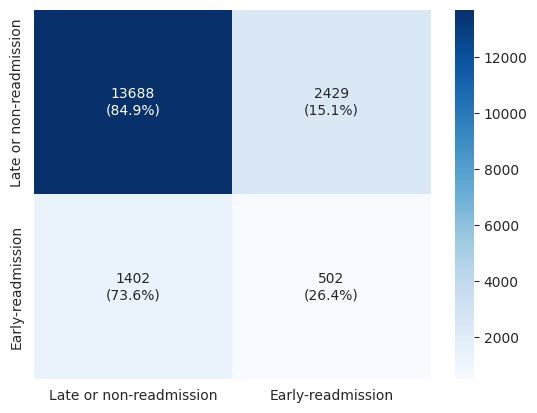

In [67]:
# Visualize confusion matrix with both absolute and percentage values
cm_smote = confusion_matrix(y_test, y_test_pred_smote)
cm_smote_norm = confusion_matrix(y_test, y_test_pred_smote, normalize='true')

annotations_smote = np.array([
    [f"{val}\n({perc:.1%})" for val, perc in zip(row, norm_row)]
    for row, norm_row in zip(cm_smote, cm_smote_norm)
])

sns.heatmap(
    cm_smote,
    annot=annotations_smote,
    cmap='Blues',
    fmt='',
    xticklabels=['Late or non-readmission', 'Early-readmission'],
    yticklabels=['Late or non-readmission', 'Early-readmission']
)

## **5. Optuna Hyper-parameter Tuning | SMOTE + Tomek Links**
Hyper-parameter tuning of the model using Optuna, by oversampling with SMOTE and undersampling with Tomek Links.

### 5.1 Objective & study setup
Preparing the objective function with all hyper-parameters, and creating/loading the Optuna study.

In [68]:
def objective(trial: optuna.Trial) -> float:
    # Hyperparameter search space
    params = {
        "n_estimators": 100,
        "max_depth": trial.suggest_int("max_depth", 14, 40, step=2),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 16, 100, step=2)
    }
    
    # Build pipeline
    pipeline = make_pipeline(
        SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'), random_state=RANDOM_STATE),
        RandomForestClassifier(**params, random_state=RANDOM_STATE)
    )
    
    # Define validation folds
    kf = StratifiedKFold(n_splits=5, shuffle=False)
    
    # Cross validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring=SCORING)

    print("Cross validation scores: {}".format(scores))
    print("Average score: {}".format(scores.mean()))

    return scores.mean()

In [69]:
# Set up study with name and storage
storage = JournalStorage(JournalFileBackend(STUDY_PATH_SMOTE_TOMEK))

study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(constant_liar=True, seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.INFO)

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/optuna/_experimental.py:31: ExperimentalWarning:

Argument ``constant_liar`` is an experimental feature. The interface can change in the future.

[I 2024-12-30 14:13:26,628] A new study created in Journal with name: Diabetes_130-US


### 5.2 Hyper-parameter tuning
**(CAUTION)** <u>Do not run</u>, unless you already need to find the best parameters. If you already have bound the best model configuration, <u>run the section above</u> _(Objective & study setup)_.

In [70]:
study.optimize(
    objective,
    n_trials=N_TRIALS,
    n_jobs=-1 # Use all available cores
)

[I 2024-12-30 14:14:05,532] Trial 2 finished with value: 0.5305862289350325 and parameters: {'max_depth': 14, 'min_samples_leaf': 94}. Best is trial 2 with value: 0.5305862289350325.


Cross validation scores: [0.52692869 0.52033813 0.53063575 0.53315684 0.54187173]
Average score: 0.5305862289350325


[I 2024-12-30 14:14:06,371] Trial 5 finished with value: 0.5317096941676486 and parameters: {'max_depth': 14, 'min_samples_leaf': 58}. Best is trial 5 with value: 0.5317096941676486.


Cross validation scores: [0.52922041 0.52397817 0.53443326 0.52940125 0.54151538]
Average score: 0.5317096941676486


[I 2024-12-30 14:14:07,921] Trial 8 finished with value: 0.5359824376347317 and parameters: {'max_depth': 36, 'min_samples_leaf': 82}. Best is trial 8 with value: 0.5359824376347317.
[I 2024-12-30 14:14:07,936] Trial 3 finished with value: 0.5376584152929966 and parameters: {'max_depth': 22, 'min_samples_leaf': 42}. Best is trial 3 with value: 0.5376584152929966.


Cross validation scores: [0.53050303 0.53367515 0.53769197 0.53332209 0.54471995]
Average score: 0.5359824376347317
Cross validation scores: [0.52973912 0.53685477 0.54394078 0.53599925 0.54175816]
Average score: 0.5376584152929966


[I 2024-12-30 14:14:08,490] Trial 1 finished with value: 0.5364369342609738 and parameters: {'max_depth': 32, 'min_samples_leaf': 38}. Best is trial 3 with value: 0.5376584152929966.


Cross validation scores: [0.53083731 0.53207381 0.54250797 0.5382268  0.53853879]
Average score: 0.5364369342609738


[I 2024-12-30 14:14:08,892] Trial 6 finished with value: 0.5354117192027312 and parameters: {'max_depth': 32, 'min_samples_leaf': 78}. Best is trial 3 with value: 0.5376584152929966.


Cross validation scores: [0.53024641 0.52981882 0.53872122 0.5315784  0.54669375]
Average score: 0.5354117192027312


[I 2024-12-30 14:14:09,486] Trial 9 finished with value: 0.5347743125951878 and parameters: {'max_depth': 32, 'min_samples_leaf': 100}. Best is trial 3 with value: 0.5376584152929966.


Cross validation scores: [0.52968464 0.53032724 0.54001605 0.53147626 0.54236737]
Average score: 0.5347743125951878


[I 2024-12-30 14:14:10,175] Trial 11 finished with value: 0.5363796279131959 and parameters: {'max_depth': 38, 'min_samples_leaf': 84}. Best is trial 3 with value: 0.5376584152929966.


Cross validation scores: [0.53201922 0.52856386 0.53977911 0.53451153 0.54702442]
Average score: 0.5363796279131959


[I 2024-12-30 14:14:10,634] Trial 4 finished with value: 0.5374638669236231 and parameters: {'max_depth': 20, 'min_samples_leaf': 56}. Best is trial 3 with value: 0.5376584152929966.


Cross validation scores: [0.52879921 0.53147443 0.54097369 0.53826688 0.54780513]
Average score: 0.5374638669236231


[I 2024-12-30 14:14:11,402] Trial 10 finished with value: 0.5348944458597831 and parameters: {'max_depth': 36, 'min_samples_leaf': 48}. Best is trial 3 with value: 0.5376584152929966.


Cross validation scores: [0.52667937 0.53043897 0.54094202 0.53746322 0.53894865]
Average score: 0.5348944458597831


[I 2024-12-30 14:14:12,128] Trial 0 finished with value: 0.5364026169278339 and parameters: {'max_depth': 28, 'min_samples_leaf': 44}. Best is trial 3 with value: 0.5376584152929966.


Cross validation scores: [0.52995593 0.53243399 0.5424084  0.53648619 0.54072858]
Average score: 0.5364026169278339


[I 2024-12-30 14:14:12,450] Trial 7 finished with value: 0.5348264159842827 and parameters: {'max_depth': 22, 'min_samples_leaf': 36}. Best is trial 3 with value: 0.5376584152929966.


Cross validation scores: [0.52683904 0.53185502 0.54486125 0.52957213 0.54100464]
Average score: 0.5348264159842827


[I 2024-12-30 14:14:46,755] Trial 13 finished with value: 0.5350948422548342 and parameters: {'max_depth': 18, 'min_samples_leaf': 68}. Best is trial 3 with value: 0.5376584152929966.


Cross validation scores: [0.53105534 0.53169746 0.53812959 0.53176953 0.54282229]
Average score: 0.5350948422548342


[I 2024-12-30 14:14:48,849] Trial 12 finished with value: 0.5356176636572895 and parameters: {'max_depth': 20, 'min_samples_leaf': 24}. Best is trial 3 with value: 0.5376584152929966.


Cross validation scores: [0.52802398 0.53728273 0.53984144 0.53506372 0.53787645]
Average score: 0.5356176636572895


[I 2024-12-30 14:14:49,631] Trial 16 finished with value: 0.5371463932051905 and parameters: {'max_depth': 22, 'min_samples_leaf': 68}. Best is trial 3 with value: 0.5376584152929966.


Cross validation scores: [0.52929584 0.53340646 0.54051794 0.53373955 0.54877217]
Average score: 0.5371463932051905


[I 2024-12-30 14:14:50,669] Trial 18 finished with value: 0.5346020578122588 and parameters: {'max_depth': 24, 'min_samples_leaf': 88}. Best is trial 3 with value: 0.5376584152929966.
[I 2024-12-30 14:14:50,726] Trial 19 finished with value: 0.5347325362476916 and parameters: {'max_depth': 24, 'min_samples_leaf': 100}. Best is trial 3 with value: 0.5376584152929966.


Cross validation scores: [0.52672158 0.52917413 0.53758669 0.53634595 0.54318193]
Average score: 0.5346020578122588
Cross validation scores: [0.53006755 0.5304071  0.53993316 0.53155937 0.54169551]
Average score: 0.5347325362476916


[I 2024-12-30 14:14:50,966] Trial 15 finished with value: 0.5354126075211092 and parameters: {'max_depth': 18, 'min_samples_leaf': 44}. Best is trial 3 with value: 0.5376584152929966.
[I 2024-12-30 14:14:51,113] Trial 14 finished with value: 0.5354507694231014 and parameters: {'max_depth': 34, 'min_samples_leaf': 26}. Best is trial 3 with value: 0.5376584152929966.


Cross validation scores: [0.52916121 0.53128719 0.53991327 0.53490627 0.5417951 ]
Average score: 0.5354126075211092
Cross validation scores: [0.52995027 0.5321014  0.54487681 0.53631758 0.53400779]
Average score: 0.5354507694231014


[I 2024-12-30 14:14:51,449] Trial 17 finished with value: 0.5340702771058108 and parameters: {'max_depth': 16, 'min_samples_leaf': 56}. Best is trial 3 with value: 0.5376584152929966.


Cross validation scores: [0.53092717 0.52444389 0.53755022 0.53484562 0.54258448]
Average score: 0.5340702771058108


[I 2024-12-30 14:14:52,010] Trial 20 finished with value: 0.5346969856795984 and parameters: {'max_depth': 20, 'min_samples_leaf': 72}. Best is trial 3 with value: 0.5376584152929966.


Cross validation scores: [0.52926135 0.52802131 0.53783088 0.5340097  0.54436169]
Average score: 0.5346969856795984


[I 2024-12-30 14:14:53,552] Trial 23 finished with value: 0.5353245692218765 and parameters: {'max_depth': 18, 'min_samples_leaf': 64}. Best is trial 3 with value: 0.5376584152929966.


Cross validation scores: [0.5285     0.52793444 0.53851238 0.53396008 0.54771594]
Average score: 0.5353245692218765


[I 2024-12-30 14:14:54,223] Trial 22 finished with value: 0.5377852863646277 and parameters: {'max_depth': 26, 'min_samples_leaf': 52}. Best is trial 22 with value: 0.5377852863646277.


Cross validation scores: [0.52914279 0.53422999 0.54256572 0.54047888 0.54250904]
Average score: 0.5377852863646277


[I 2024-12-30 14:14:57,013] Trial 21 finished with value: 0.5295462869544661 and parameters: {'max_depth': 28, 'min_samples_leaf': 16}. Best is trial 22 with value: 0.5377852863646277.


Cross validation scores: [0.52483195 0.53130891 0.53578221 0.53039191 0.52541646]
Average score: 0.5295462869544661


[I 2024-12-30 14:15:29,144] Trial 24 finished with value: 0.5347768770927859 and parameters: {'max_depth': 26, 'min_samples_leaf': 34}. Best is trial 22 with value: 0.5377852863646277.


Cross validation scores: [0.52766083 0.5334283  0.54302888 0.53122694 0.53853942]
Average score: 0.5347768770927859


[I 2024-12-30 14:15:31,362] Trial 25 finished with value: 0.5375762785335073 and parameters: {'max_depth': 30, 'min_samples_leaf': 52}. Best is trial 22 with value: 0.5377852863646277.


Cross validation scores: [0.52706021 0.53497516 0.54102611 0.53982623 0.54499369]
Average score: 0.5375762785335073


[I 2024-12-30 14:15:31,673] Trial 27 finished with value: 0.5347243743986733 and parameters: {'max_depth': 40, 'min_samples_leaf': 62}. Best is trial 22 with value: 0.5377852863646277.


Cross validation scores: [0.53015528 0.5281451  0.53789082 0.53508671 0.54234396]
Average score: 0.5347243743986733


[I 2024-12-30 14:15:32,249] Trial 26 finished with value: 0.5356673898711388 and parameters: {'max_depth': 22, 'min_samples_leaf': 30}. Best is trial 22 with value: 0.5377852863646277.


Cross validation scores: [0.5276855  0.53477419 0.5411939  0.53549113 0.53919224]
Average score: 0.5356673898711388


[I 2024-12-30 14:15:33,698] Trial 29 finished with value: 0.5336685212553923 and parameters: {'max_depth': 16, 'min_samples_leaf': 20}. Best is trial 22 with value: 0.5377852863646277.


Cross validation scores: [0.5293697  0.52597362 0.53849766 0.53424949 0.54025213]
Average score: 0.5336685212553923


[I 2024-12-30 14:15:34,117] Trial 28 finished with value: 0.5369503733471774 and parameters: {'max_depth': 24, 'min_samples_leaf': 44}. Best is trial 22 with value: 0.5377852863646277.


Cross validation scores: [0.52926628 0.53134663 0.54459067 0.53696242 0.54258587]
Average score: 0.5369503733471774


[I 2024-12-30 14:15:34,467] Trial 32 finished with value: 0.5356628800247524 and parameters: {'max_depth': 22, 'min_samples_leaf': 74}. Best is trial 22 with value: 0.5377852863646277.


Cross validation scores: [0.5303734  0.533724   0.53719297 0.53281679 0.54420725]
Average score: 0.5356628800247524


[I 2024-12-30 14:15:34,775] Trial 33 finished with value: 0.5330672333457933 and parameters: {'max_depth': 16, 'min_samples_leaf': 62}. Best is trial 22 with value: 0.5377852863646277.
[I 2024-12-30 14:15:34,794] Trial 30 finished with value: 0.5359930203544897 and parameters: {'max_depth': 30, 'min_samples_leaf': 38}. Best is trial 22 with value: 0.5377852863646277.


Cross validation scores: [0.52765962 0.52584934 0.53428487 0.53487654 0.5426658 ]
Average score: 0.5330672333457933
Cross validation scores: [0.53059473 0.5323143  0.54079434 0.5382268  0.53803494]
Average score: 0.5359930203544897


[I 2024-12-30 14:15:35,544] Trial 31 finished with value: 0.5357203337527678 and parameters: {'max_depth': 20, 'min_samples_leaf': 42}. Best is trial 22 with value: 0.5377852863646277.


Cross validation scores: [0.52797817 0.53419889 0.54328114 0.53306335 0.54008012]
Average score: 0.5357203337527678


[I 2024-12-30 14:15:36,436] Trial 34 finished with value: 0.5377852863646277 and parameters: {'max_depth': 26, 'min_samples_leaf': 52}. Best is trial 22 with value: 0.5377852863646277.


Cross validation scores: [0.52914279 0.53422999 0.54256572 0.54047888 0.54250904]
Average score: 0.5377852863646277


[I 2024-12-30 14:15:38,439] Trial 35 finished with value: 0.5377852863646277 and parameters: {'max_depth': 26, 'min_samples_leaf': 52}. Best is trial 22 with value: 0.5377852863646277.


Cross validation scores: [0.52914279 0.53422999 0.54256572 0.54047888 0.54250904]
Average score: 0.5377852863646277


[I 2024-12-30 14:16:09,750] Trial 36 finished with value: 0.5361775691774302 and parameters: {'max_depth': 30, 'min_samples_leaf': 58}. Best is trial 22 with value: 0.5377852863646277.


Cross validation scores: [0.52642116 0.5341707  0.53982991 0.53392997 0.54653612]
Average score: 0.5361775691774302


[I 2024-12-30 14:16:11,802] Trial 37 finished with value: 0.5346903433228862 and parameters: {'max_depth': 30, 'min_samples_leaf': 48}. Best is trial 22 with value: 0.5377852863646277.


Cross validation scores: [0.52720763 0.53035867 0.54094202 0.53746322 0.53748017]
Average score: 0.5346903433228862


[I 2024-12-30 14:16:13,198] Trial 38 finished with value: 0.5334948310855226 and parameters: {'max_depth': 28, 'min_samples_leaf': 40}. Best is trial 22 with value: 0.5377852863646277.


Cross validation scores: [0.52933145 0.52813414 0.54098495 0.53288184 0.53614178]
Average score: 0.5334948310855226


[I 2024-12-30 14:16:13,598] Trial 44 finished with value: 0.5329884926700601 and parameters: {'max_depth': 14, 'min_samples_leaf': 66}. Best is trial 22 with value: 0.5377852863646277.


Cross validation scores: [0.52703275 0.52669018 0.53384973 0.53573771 0.54163209]
Average score: 0.5329884926700601


[I 2024-12-30 14:16:14,083] Trial 39 finished with value: 0.5361720637116433 and parameters: {'max_depth': 34, 'min_samples_leaf': 34}. Best is trial 22 with value: 0.5377852863646277.


Cross validation scores: [0.52820166 0.53534894 0.5434753  0.53394126 0.53989315]
Average score: 0.5361720637116433


[I 2024-12-30 14:16:14,435] Trial 40 finished with value: 0.5369803314077867 and parameters: {'max_depth': 28, 'min_samples_leaf': 50}. Best is trial 22 with value: 0.5377852863646277.


Cross validation scores: [0.52654042 0.5312228  0.54021597 0.53802883 0.54889365]
Average score: 0.5369803314077867


[I 2024-12-30 14:16:14,944] Trial 41 finished with value: 0.5359644275994183 and parameters: {'max_depth': 32, 'min_samples_leaf': 54}. Best is trial 22 with value: 0.5377852863646277.


Cross validation scores: [0.5317601  0.52976898 0.5384784  0.53482404 0.54499062]
Average score: 0.5359644275994183


[I 2024-12-30 14:16:15,885] Trial 42 finished with value: 0.5357730676679763 and parameters: {'max_depth': 24, 'min_samples_leaf': 46}. Best is trial 22 with value: 0.5377852863646277.


Cross validation scores: [0.5276571  0.53620375 0.54314058 0.53220525 0.53965865]
Average score: 0.5357730676679763


[I 2024-12-30 14:16:16,105] Trial 43 finished with value: 0.536227594596473 and parameters: {'max_depth': 26, 'min_samples_leaf': 58}. Best is trial 22 with value: 0.5377852863646277.


Cross validation scores: [0.52614082 0.53472329 0.53933041 0.53484091 0.54610255]
Average score: 0.536227594596473


[I 2024-12-30 14:16:18,023] Trial 45 finished with value: 0.5332569217769588 and parameters: {'max_depth': 20, 'min_samples_leaf': 28}. Best is trial 22 with value: 0.5377852863646277.


Cross validation scores: [0.52658376 0.52528241 0.54312633 0.53409889 0.53719322]
Average score: 0.5332569217769588


[I 2024-12-30 14:16:18,459] Trial 46 finished with value: 0.5377852863646277 and parameters: {'max_depth': 26, 'min_samples_leaf': 52}. Best is trial 22 with value: 0.5377852863646277.


Cross validation scores: [0.52914279 0.53422999 0.54256572 0.54047888 0.54250904]
Average score: 0.5377852863646277


[I 2024-12-30 14:16:19,948] Trial 47 finished with value: 0.5346988359381868 and parameters: {'max_depth': 26, 'min_samples_leaf': 32}. Best is trial 22 with value: 0.5377852863646277.


Cross validation scores: [0.5273496  0.52974575 0.54136263 0.53581388 0.53922231]
Average score: 0.5346988359381868


[I 2024-12-30 14:16:51,310] Trial 48 finished with value: 0.5344394710101336 and parameters: {'max_depth': 24, 'min_samples_leaf': 40}. Best is trial 22 with value: 0.5377852863646277.


Cross validation scores: [0.53037579 0.53192222 0.53919034 0.5304053  0.54030372]
Average score: 0.5344394710101336


[I 2024-12-30 14:16:52,370] Trial 49 finished with value: 0.5354905129645836 and parameters: {'max_depth': 28, 'min_samples_leaf': 48}. Best is trial 22 with value: 0.5377852863646277.


Cross validation scores: [0.52712871 0.53100202 0.54205809 0.53746322 0.53980052]
Average score: 0.5354905129645836


[I 2024-12-30 14:16:54,130] Trial 50 finished with value: 0.5385367658384365 and parameters: {'max_depth': 22, 'min_samples_leaf': 60}. Best is trial 50 with value: 0.5385367658384365.


Cross validation scores: [0.53163973 0.53614671 0.54350334 0.53660587 0.54478819]
Average score: 0.5385367658384365


[I 2024-12-30 14:16:54,431] Trial 51 finished with value: 0.5361415763020105 and parameters: {'max_depth': 26, 'min_samples_leaf': 54}. Best is trial 50 with value: 0.5385367658384365.


Cross validation scores: [0.53107814 0.53066445 0.54064333 0.53422073 0.54410123]
Average score: 0.5361415763020105


[I 2024-12-30 14:16:55,309] Trial 52 finished with value: 0.5375762785335073 and parameters: {'max_depth': 30, 'min_samples_leaf': 52}. Best is trial 50 with value: 0.5385367658384365.


Cross validation scores: [0.52706021 0.53497516 0.54102611 0.53982623 0.54499369]
Average score: 0.5375762785335073


[I 2024-12-30 14:16:56,196] Trial 53 finished with value: 0.5361940853621917 and parameters: {'max_depth': 32, 'min_samples_leaf': 44}. Best is trial 50 with value: 0.5385367658384365.


Cross validation scores: [0.52974628 0.53254459 0.54195175 0.53648619 0.54024162]
Average score: 0.5361940853621917


[I 2024-12-30 14:16:56,955] Trial 56 finished with value: 0.5364679942426053 and parameters: {'max_depth': 24, 'min_samples_leaf': 70}. Best is trial 50 with value: 0.5385367658384365.
[I 2024-12-30 14:16:56,993] Trial 55 finished with value: 0.5366687219357921 and parameters: {'max_depth': 34, 'min_samples_leaf': 56}. Best is trial 50 with value: 0.5385367658384365.
[I 2024-12-30 14:16:56,998] Trial 54 finished with value: 0.5369803314077867 and parameters: {'max_depth': 28, 'min_samples_leaf': 50}. Best is trial 50 with value: 0.5385367658384365.


Cross validation scores: [0.53166144 0.53380614 0.5377804  0.53403461 0.54505739]
Average score: 0.5364679942426053
Cross validation scores: [0.53200596 0.53368182 0.54113077 0.53342701 0.54309805]
Average score: 0.5366687219357921
Cross validation scores: [0.52654042 0.5312228  0.54021597 0.53802883 0.54889365]
Average score: 0.5369803314077867


[I 2024-12-30 14:16:59,220] Trial 57 finished with value: 0.5340983227028806 and parameters: {'max_depth': 26, 'min_samples_leaf': 36}. Best is trial 50 with value: 0.5385367658384365.


Cross validation scores: [0.52508036 0.53221289 0.54114441 0.53685129 0.53520266]
Average score: 0.5340983227028806


[I 2024-12-30 14:17:00,161] Trial 58 finished with value: 0.5371813875911171 and parameters: {'max_depth': 22, 'min_samples_leaf': 54}. Best is trial 50 with value: 0.5385367658384365.


Cross validation scores: [0.53003246 0.52974946 0.54226578 0.53742914 0.5464301 ]
Average score: 0.5371813875911171


[I 2024-12-30 14:17:01,472] Trial 59 finished with value: 0.5357787401320764 and parameters: {'max_depth': 26, 'min_samples_leaf': 46}. Best is trial 50 with value: 0.5385367658384365.


Cross validation scores: [0.52591496 0.53658016 0.54125734 0.5338713  0.54126994]
Average score: 0.5357787401320764


[I 2024-12-30 14:17:32,200] Trial 60 finished with value: 0.5378039239593321 and parameters: {'max_depth': 24, 'min_samples_leaf': 64}. Best is trial 50 with value: 0.5385367658384365.


Cross validation scores: [0.53133982 0.53437588 0.53997842 0.53760811 0.54571738]
Average score: 0.5378039239593321


[I 2024-12-30 14:17:33,012] Trial 61 finished with value: 0.5367401604079205 and parameters: {'max_depth': 26, 'min_samples_leaf': 76}. Best is trial 50 with value: 0.5385367658384365.


Cross validation scores: [0.5312477  0.53374105 0.54016618 0.53376557 0.5447803 ]
Average score: 0.5367401604079205


[I 2024-12-30 14:17:35,365] Trial 62 finished with value: 0.5357152645678338 and parameters: {'max_depth': 22, 'min_samples_leaf': 58}. Best is trial 50 with value: 0.5385367658384365.


Cross validation scores: [0.5257136  0.53636789 0.53974868 0.53418556 0.54256059]
Average score: 0.5357152645678338


[I 2024-12-30 14:17:35,799] Trial 63 finished with value: 0.5353124594759934 and parameters: {'max_depth': 22, 'min_samples_leaf': 62}. Best is trial 50 with value: 0.5385367658384365.


Cross validation scores: [0.53013804 0.53142782 0.53953876 0.53179581 0.54366186]
Average score: 0.5353124594759934


[I 2024-12-30 14:17:36,459] Trial 64 finished with value: 0.5354353843965334 and parameters: {'max_depth': 18, 'min_samples_leaf': 60}. Best is trial 50 with value: 0.5385367658384365.


Cross validation scores: [0.52526553 0.53397984 0.53932197 0.53518195 0.54342764]
Average score: 0.5354353843965334


[I 2024-12-30 14:17:37,121] Trial 66 finished with value: 0.5357204911914013 and parameters: {'max_depth': 20, 'min_samples_leaf': 82}. Best is trial 50 with value: 0.5385367658384365.


Cross validation scores: [0.52853444 0.53244835 0.53960014 0.53300689 0.54501264]
Average score: 0.5357204911914013


[I 2024-12-30 14:17:38,061] Trial 65 finished with value: 0.5364245551723898 and parameters: {'max_depth': 24, 'min_samples_leaf': 50}. Best is trial 50 with value: 0.5385367658384365.


Cross validation scores: [0.52862207 0.53226318 0.54156034 0.53592399 0.5437532 ]
Average score: 0.5364245551723898


[I 2024-12-30 14:17:39,492] Trial 69 finished with value: 0.5371463932051905 and parameters: {'max_depth': 22, 'min_samples_leaf': 68}. Best is trial 50 with value: 0.5385367658384365.


Cross validation scores: [0.52929584 0.53340646 0.54051794 0.53373955 0.54877217]
Average score: 0.5371463932051905


[I 2024-12-30 14:17:40,092] Trial 67 finished with value: 0.5353902935737065 and parameters: {'max_depth': 28, 'min_samples_leaf': 42}. Best is trial 50 with value: 0.5385367658384365.
[I 2024-12-30 14:17:40,156] Trial 68 finished with value: 0.5353902935737065 and parameters: {'max_depth': 28, 'min_samples_leaf': 42}. Best is trial 50 with value: 0.5385367658384365.


Cross validation scores: [0.52716345 0.53192222 0.54054315 0.53393003 0.54339263]
Average score: 0.5353902935737065
Cross validation scores: [0.52716345 0.53192222 0.54054315 0.53393003 0.54339263]
Average score: 0.5353902935737065


[I 2024-12-30 14:17:42,639] Trial 70 finished with value: 0.5368541616641068 and parameters: {'max_depth': 24, 'min_samples_leaf': 52}. Best is trial 50 with value: 0.5385367658384365.


Cross validation scores: [0.52975413 0.53300692 0.53974314 0.53836383 0.5434028 ]
Average score: 0.5368541616641068


[I 2024-12-30 14:17:43,588] Trial 71 finished with value: 0.5357787401320764 and parameters: {'max_depth': 26, 'min_samples_leaf': 46}. Best is trial 50 with value: 0.5385367658384365.


Cross validation scores: [0.52591496 0.53658016 0.54125734 0.5338713  0.54126994]
Average score: 0.5357787401320764


[I 2024-12-30 14:18:14,704] Trial 72 finished with value: 0.5392705752726263 and parameters: {'max_depth': 24, 'min_samples_leaf': 66}. Best is trial 72 with value: 0.5392705752726263.


Cross validation scores: [0.53363329 0.53538623 0.54446445 0.53871417 0.54415474]
Average score: 0.5392705752726263


[I 2024-12-30 14:18:15,530] Trial 73 finished with value: 0.5385367658384365 and parameters: {'max_depth': 22, 'min_samples_leaf': 60}. Best is trial 72 with value: 0.5392705752726263.


Cross validation scores: [0.53163973 0.53614671 0.54350334 0.53660587 0.54478819]
Average score: 0.5385367658384365


[I 2024-12-30 14:18:16,923] Trial 74 finished with value: 0.5378039239593321 and parameters: {'max_depth': 24, 'min_samples_leaf': 64}. Best is trial 72 with value: 0.5392705752726263.


Cross validation scores: [0.53133982 0.53437588 0.53997842 0.53760811 0.54571738]
Average score: 0.5378039239593321


[I 2024-12-30 14:18:18,065] Trial 75 finished with value: 0.5376688422512459 and parameters: {'max_depth': 26, 'min_samples_leaf': 60}. Best is trial 72 with value: 0.5392705752726263.


Cross validation scores: [0.52733549 0.53782426 0.54302434 0.53385875 0.54630137]
Average score: 0.5376688422512459


[I 2024-12-30 14:18:19,540] Trial 78 finished with value: 0.5352694388399419 and parameters: {'max_depth': 20, 'min_samples_leaf': 90}. Best is trial 72 with value: 0.5392705752726263.


Cross validation scores: [0.5300364  0.52877521 0.5390209  0.53226628 0.5462484 ]
Average score: 0.5352694388399419


[I 2024-12-30 14:18:19,860] Trial 76 finished with value: 0.537666709276397 and parameters: {'max_depth': 22, 'min_samples_leaf': 56}. Best is trial 72 with value: 0.5392705752726263.
[I 2024-12-30 14:18:19,877] Trial 77 finished with value: 0.5364679942426053 and parameters: {'max_depth': 24, 'min_samples_leaf': 70}. Best is trial 72 with value: 0.5392705752726263.


Cross validation scores: [0.53103118 0.53314486 0.54428512 0.5352268  0.54464559]
Average score: 0.537666709276397
Cross validation scores: [0.53166144 0.53380614 0.5377804  0.53403461 0.54505739]
Average score: 0.5364679942426053


[I 2024-12-30 14:18:20,360] Trial 79 finished with value: 0.5385640419810389 and parameters: {'max_depth': 26, 'min_samples_leaf': 64}. Best is trial 72 with value: 0.5392705752726263.


Cross validation scores: [0.5330143  0.53247698 0.54203682 0.53773699 0.54755511]
Average score: 0.5385640419810389


[I 2024-12-30 14:18:22,457] Trial 80 finished with value: 0.5359593698872188 and parameters: {'max_depth': 28, 'min_samples_leaf': 54}. Best is trial 72 with value: 0.5392705752726263.


Cross validation scores: [0.53047563 0.53053761 0.53932552 0.53504187 0.54441622]
Average score: 0.5359593698872188


[I 2024-12-30 14:18:23,651] Trial 81 finished with value: 0.5356705559742428 and parameters: {'max_depth': 20, 'min_samples_leaf': 38}. Best is trial 72 with value: 0.5392705752726263.


Cross validation scores: [0.52631469 0.53594375 0.53785698 0.53829864 0.53993872]
Average score: 0.5356705559742428


[I 2024-12-30 14:18:25,757] Trial 82 finished with value: 0.5368541616641068 and parameters: {'max_depth': 24, 'min_samples_leaf': 52}. Best is trial 72 with value: 0.5392705752726263.


Cross validation scores: [0.52975413 0.53300692 0.53974314 0.53836383 0.5434028 ]
Average score: 0.5368541616641068


[I 2024-12-30 14:18:26,461] Trial 83 finished with value: 0.5346903433228862 and parameters: {'max_depth': 30, 'min_samples_leaf': 48}. Best is trial 72 with value: 0.5392705752726263.


Cross validation scores: [0.52720763 0.53035867 0.54094202 0.53746322 0.53748017]
Average score: 0.5346903433228862


[I 2024-12-30 14:18:55,959] Trial 84 finished with value: 0.5392705752726263 and parameters: {'max_depth': 24, 'min_samples_leaf': 66}. Best is trial 72 with value: 0.5392705752726263.


Cross validation scores: [0.53363329 0.53538623 0.54446445 0.53871417 0.54415474]
Average score: 0.5392705752726263


[I 2024-12-30 14:18:57,394] Trial 85 finished with value: 0.5385367658384365 and parameters: {'max_depth': 22, 'min_samples_leaf': 60}. Best is trial 72 with value: 0.5392705752726263.


Cross validation scores: [0.53163973 0.53614671 0.54350334 0.53660587 0.54478819]
Average score: 0.5385367658384365


[I 2024-12-30 14:18:58,612] Trial 86 finished with value: 0.5378039239593321 and parameters: {'max_depth': 24, 'min_samples_leaf': 64}. Best is trial 72 with value: 0.5392705752726263.


Cross validation scores: [0.53133982 0.53437588 0.53997842 0.53760811 0.54571738]
Average score: 0.5378039239593321


[I 2024-12-30 14:18:59,137] Trial 87 finished with value: 0.5353209207377878 and parameters: {'max_depth': 24, 'min_samples_leaf': 78}. Best is trial 72 with value: 0.5392705752726263.


Cross validation scores: [0.5295288  0.5298404  0.53870629 0.5314058  0.54712331]
Average score: 0.5353209207377878


[I 2024-12-30 14:19:01,663] Trial 89 finished with value: 0.5361592914467262 and parameters: {'max_depth': 18, 'min_samples_leaf': 66}. Best is trial 72 with value: 0.5392705752726263.
[I 2024-12-30 14:19:01,682] Trial 88 finished with value: 0.5367131992064165 and parameters: {'max_depth': 22, 'min_samples_leaf': 72}. Best is trial 72 with value: 0.5392705752726263.


Cross validation scores: [0.5336652  0.53132158 0.53697858 0.53668102 0.54215009]
Average score: 0.5361592914467262
Cross validation scores: [0.52868713 0.53240344 0.54249321 0.5363854  0.54359682]
Average score: 0.5367131992064165


[I 2024-12-30 14:19:01,885] Trial 91 finished with value: 0.5385640419810389 and parameters: {'max_depth': 26, 'min_samples_leaf': 64}. Best is trial 72 with value: 0.5392705752726263.


Cross validation scores: [0.5330143  0.53247698 0.54203682 0.53773699 0.54755511]
Average score: 0.5385640419810389


[I 2024-12-30 14:19:02,384] Trial 90 finished with value: 0.5357152645678338 and parameters: {'max_depth': 22, 'min_samples_leaf': 58}. Best is trial 72 with value: 0.5392705752726263.


Cross validation scores: [0.5257136  0.53636789 0.53974868 0.53418556 0.54256059]
Average score: 0.5357152645678338


[I 2024-12-30 14:19:03,050] Trial 92 finished with value: 0.5354532720587705 and parameters: {'max_depth': 26, 'min_samples_leaf': 62}. Best is trial 72 with value: 0.5392705752726263.


Cross validation scores: [0.52973911 0.53059733 0.53838651 0.53553398 0.54300944]
Average score: 0.5354532720587705


[I 2024-12-30 14:19:03,977] Trial 93 finished with value: 0.5375143209266174 and parameters: {'max_depth': 24, 'min_samples_leaf': 68}. Best is trial 72 with value: 0.5392705752726263.


Cross validation scores: [0.53168304 0.53129243 0.54218172 0.53311544 0.54929897]
Average score: 0.5375143209266174


[I 2024-12-30 14:19:05,612] Trial 94 finished with value: 0.5385640419810389 and parameters: {'max_depth': 26, 'min_samples_leaf': 64}. Best is trial 72 with value: 0.5392705752726263.


Cross validation scores: [0.5330143  0.53247698 0.54203682 0.53773699 0.54755511]
Average score: 0.5385640419810389


[I 2024-12-30 14:19:05,879] Trial 95 finished with value: 0.537655826794805 and parameters: {'max_depth': 28, 'min_samples_leaf': 60}. Best is trial 72 with value: 0.5392705752726263.


Cross validation scores: [0.52776795 0.53707878 0.54244635 0.53500996 0.5459761 ]
Average score: 0.537655826794805


[I 2024-12-30 14:19:20,787] Trial 96 finished with value: 0.5392705752726263 and parameters: {'max_depth': 24, 'min_samples_leaf': 66}. Best is trial 72 with value: 0.5392705752726263.


Cross validation scores: [0.53363329 0.53538623 0.54446445 0.53871417 0.54415474]
Average score: 0.5392705752726263


[I 2024-12-30 14:19:21,052] Trial 97 finished with value: 0.5356628800247524 and parameters: {'max_depth': 22, 'min_samples_leaf': 74}. Best is trial 72 with value: 0.5392705752726263.


Cross validation scores: [0.5303734  0.533724   0.53719297 0.53281679 0.54420725]
Average score: 0.5356628800247524


[I 2024-12-30 14:19:21,998] Trial 98 finished with value: 0.5368676836369055 and parameters: {'max_depth': 20, 'min_samples_leaf': 64}. Best is trial 72 with value: 0.5392705752726263.


Cross validation scores: [0.53015971 0.53252911 0.53907977 0.53632054 0.54624929]
Average score: 0.5368676836369055


[I 2024-12-30 14:19:22,218] Trial 99 finished with value: 0.5364679942426053 and parameters: {'max_depth': 24, 'min_samples_leaf': 70}. Best is trial 72 with value: 0.5392705752726263.


Cross validation scores: [0.53166144 0.53380614 0.5377804  0.53403461 0.54505739]
Average score: 0.5364679942426053


In [71]:
print('Best Trial: {}'.format(study.best_trial.number))
print('Best Parameters: {}'.format(study.best_params))
print('Best Value: {}'.format(study.best_value))

Best Trial: 72
Best Parameters: {'max_depth': 24, 'min_samples_leaf': 66}
Best Value: 0.5392705752726263


### 5.3 Optuna Visualizations
Visualizing hyper-parameter tuning results obtained by running Optuna.

In [72]:
optuna.visualization.plot_optimization_history(study)

In [73]:
optuna.visualization.plot_slice(study)

In [74]:
optuna.visualization.plot_param_importances(study)

In [75]:
optuna.visualization.plot_parallel_coordinate(study)

In [76]:
optuna.visualization.plot_contour(study)

In [77]:
optuna.visualization.plot_timeline(study)

### 5.4 Fitting Best Model
Fitting the final model using the best hyper-parameters found by Optuna.

In [78]:
# Fit best model on the training set
best_params = study.best_params

pipeline_smotetomek = make_pipeline(
    SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'), random_state=RANDOM_STATE),
    RandomForestClassifier(**best_params, random_state=RANDOM_STATE)
)

pipeline_smotetomek.fit(X_train, y_train)

Pipeline(steps=[('smotetomek',
                 SMOTETomek(random_state=38,
                            tomek=TomekLinks(sampling_strategy='majority'))),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=24, min_samples_leaf=66,
                                        random_state=38))])

In [79]:
# Predictions
y_train_pred_smotetomek = pipeline_smotetomek.predict(X_train)
y_test_pred_smotetomek = pipeline_smotetomek.predict(X_test)

In [80]:
ac_train_smotetomek = accuracy_score(y_train, y_train_pred_smotetomek)
ac_test_smotetomek = accuracy_score(y_test, y_test_pred_smotetomek)

print('Train accuracy: ', ac_train_smotetomek)
print('Test accuracy: ', ac_test_smotetomek)

Train accuracy:  0.7998715753424658
Test accuracy:  0.7786471338993397


In [81]:
# Visualize precision, recall, F1-score
print(classification_report(
    y_test, y_test_pred_smotetomek,
    target_names=['Late or non-readmission', 'Early-readmission']
))

                         precision    recall  f1-score   support

Late or non-readmission       0.91      0.84      0.87     16117
      Early-readmission       0.17      0.27      0.21      1904

               accuracy                           0.78     18021
              macro avg       0.54      0.56      0.54     18021
           weighted avg       0.83      0.78      0.80     18021



In [82]:
# Compute precision, recall, F1-score, ROC-AUC-score, and accuracy
recall_smotetomek = recall_score(y_test, y_test_pred_smotetomek, average='macro')
precision_smotetomek = precision_score(y_test, y_test_pred_smotetomek, average='macro')
f1_smotetomek = f1_score(y_test, y_test_pred_smotetomek, average='macro')
roc_auc_smotetomek = roc_auc_score(y_test, y_test_pred_smotetomek, average='macro')
accuracy_smotetomek = accuracy_score(y_test, y_test_pred_smotetomek)

<Axes: >

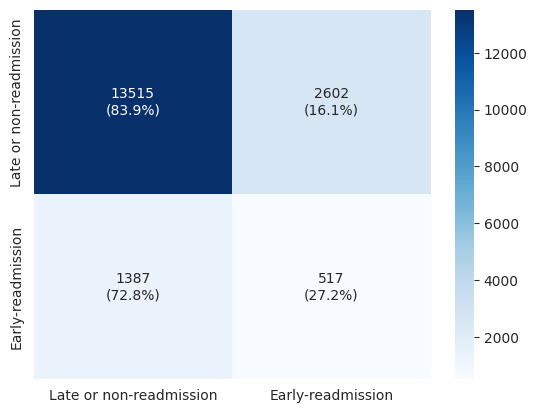

In [83]:
# Visualize confusion matrix with both absolute and percentage values
cm_smotetomek = confusion_matrix(y_test, y_test_pred_smotetomek)
cm_smotetomek_norm = confusion_matrix(y_test, y_test_pred_smotetomek, normalize='true')

annotations_smotetomek = np.array([
    [f"{val}\n({perc:.1%})" for val, perc in zip(row, norm_row)]
    for row, norm_row in zip(cm_smotetomek, cm_smotetomek_norm)
])

sns.heatmap(
    cm_smotetomek,
    annot=annotations_smotetomek,
    cmap='Blues',
    fmt='',
    xticklabels=['Late or non-readmission', 'Early-readmission'],
    yticklabels=['Late or non-readmission', 'Early-readmission']
)

## **6. Results Combined**
Visualizing all results obtained by different sampling methods, on the best respective models.

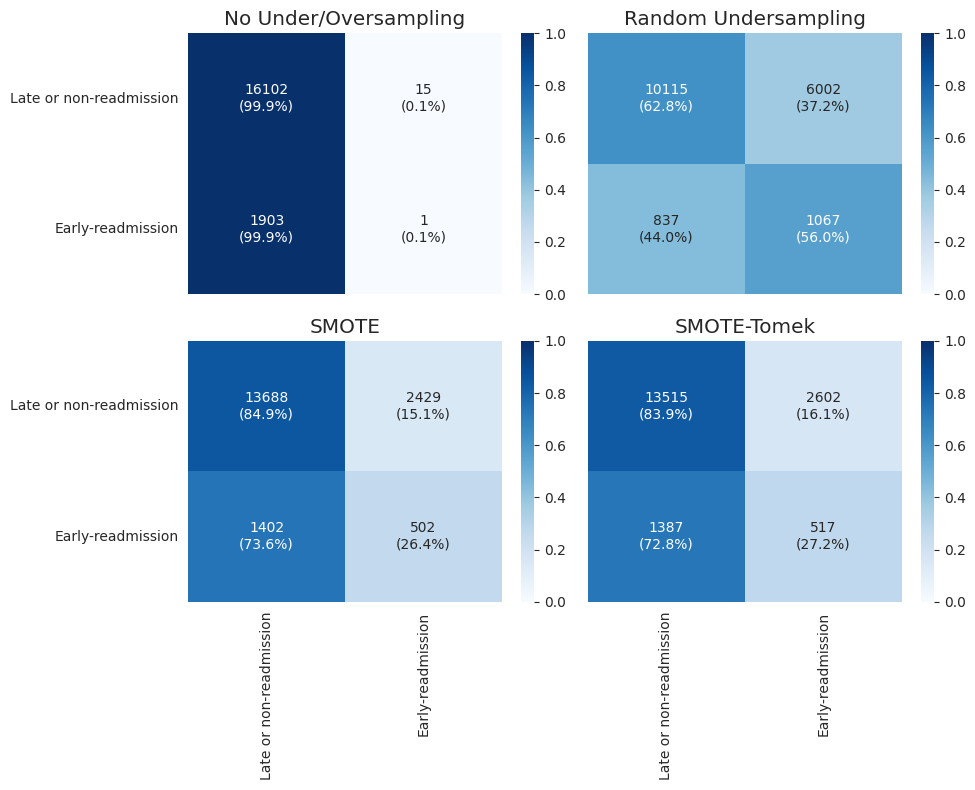

In [84]:
# Combine all confusion matrices into a single plot
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
cm_list = [cm_none_norm, cm_rus_norm, cm_smote_norm, cm_smotetomek_norm]
annotations = [annotations_none, annotations_rus, annotations_smote, annotations_smotetomek]
labels = ['No Under/Oversampling', 'Random Undersampling', 'SMOTE', 'SMOTE-Tomek']

# Define tick labels
xticklabels = ['Late or non-readmission', 'Early-readmission']
yticklabels = ['Late or non-readmission', 'Early-readmission']

for i, cm in enumerate(cm_list):
    ax=axs[i//2, i%2]
    sns.heatmap(
        cm,
        annot=annotations[i],
        cmap='Blues',
        fmt='',
        vmin=0, vmax=1,
        ax=axs[i//2, i%2],
        xticklabels=['Late or non-readmission', 'Early-readmission'],
        yticklabels=['Late or non-readmission', 'Early-readmission']
    )
    ax.set_title(labels[i])
    
    # Hide x-tick labels for the top row
    if i < 2:
        ax.set_xticklabels([])
    # Hide y-tick labels for the right column
    if i % 2 == 1:
        ax.set_yticklabels([])

plt.tight_layout()
plt.show()

Visualizing the scores for each method.

In [85]:
# Combine all metrics into a single DataFrame
data = {
    'Recall': [recall_none, recall_rus, recall_smote, recall_smotetomek],
    'Precision': [precision_none, precision_rus, precision_smote, precision_smotetomek],
    'F1-score': [f1_none, f1_rus, f1_smote, f1_smotetomek],
    'ROC-AUC': [roc_auc_none, roc_auc_rus, roc_auc_smote, roc_auc_smotetomek],
    'Accuracy': [accuracy_none, accuracy_rus, accuracy_smote, accuracy_smotetomek]
}

metrics_df = pd.DataFrame(data, index=labels)
metrics_df

,Recall,Precision,F1-score,ROC-AUC,Accuracy
No Under/Oversampling,0.499797,0.478404,0.472416,0.499797,0.893569
Random Undersampling,0.593999,0.537258,0.492587,0.593999,0.620498
SMOTE,0.556473,0.539182,0.542446,0.556473,0.787415
SMOTE-Tomek,0.555045,0.536342,0.538627,0.555045,0.778647


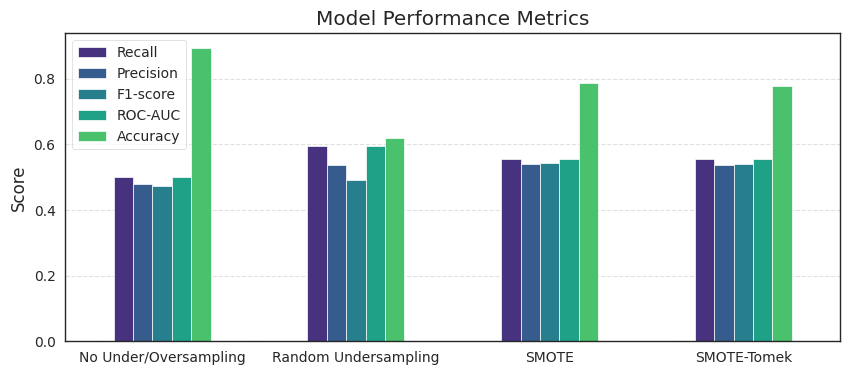

In [98]:
# Visualize all metrics in a bar plot, by coloring each method differently, using SeaBorn barplot and adding grids
sns.set_palette('viridis')
metrics_df.plot(kind='bar', figsize=(10, 4))
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()